# 🚀 SkyGeni Sales Intelligence — EDA & Insights
### Part 2: Exploratory Data Analysis
---
> **Objective:** Investigate the CRO's complaint : *'Win rate has dropped over the last two quarters, but pipeline volume looks healthy. I don't know what's going wrong.'*

## Setup & Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# ── Global style ──────────────────────────────────────────────────────────────
plt.rcParams.update({
    'figure.facecolor': '#0F1117',
    'axes.facecolor':   '#1A1D2E',
    'axes.edgecolor':   '#2E3250',
    'axes.labelcolor':  '#C8CDE8',
    'xtick.color':      '#8B90B8',
    'ytick.color':      '#8B90B8',
    'text.color':       '#E8EAF6',
    'grid.color':       '#2E3250',
    'grid.linestyle':   '--',
    'grid.alpha':       0.5,
    'font.family':      'DejaVu Sans',
    'font.size':        11,
    'axes.titlesize':   14,
    'axes.titleweight': 'bold',
})

# Brand palette
WON_COLOR  = '#00E5A0'   # emerald green
LOST_COLOR = '#FF4D6D'   # vivid red
ACCENT     = '#7B8CDE'   # periwinkle
ACCENT2    = '#FFB347'   # amber
PALETTE    = [WON_COLOR, LOST_COLOR, ACCENT, ACCENT2, '#BB86FC', '#03DAC6']

print('✅ Setup complete')

✅ Setup complete


## Load & Inspect Data — Dataset Sanity Check

**What this confirms**
- The dataset contains **5,000 deals** with **12 relevant fields** covering deal attributes, sales process, and outcome.
- There are **no missing values** across any columns → no imputation needed for downstream analysis or modeling.
- Outcome distribution:
  - **Won:** 2,263  
  - **Lost:** 2,737  
  - **Overall win rate: 45.3%**

**Why this matters (business context)**
- A **45.3% win rate** is meaningfully below what many B2B SaaS orgs target (typically ~50–60% for qualified pipeline), validating the CRO’s concern that win rate has dropped.
- The slightly higher number of **Lost vs Won deals** suggests that identifying win-rate drivers and loss-risk factors can unlock meaningful revenue upside.
- Since the data is complete and consistent, downstream insights and models are less likely to be biased by data quality issues.

**How this is used going forward**
- This dataset is suitable for:
  - Segment-level win rate analysis (by region, product, lead source, rep)
  - Sales cycle vs outcome analysis  
  - Building a lightweight win-rate driver model (Part 3)
- The class balance (~45/55) is reasonable for modeling without aggressive rebalancing.
ressive rebalancing.


In [5]:
df = pd.read_csv('skygeni_sales_data.csv', parse_dates=['created_date', 'closed_date'])

print(f'Shape : {df.shape}')
print(f'Columns: {list(df.columns)}')
print(f'Date range: {df["created_date"].min().date()} → {df["created_date"].max().date()}')
df.head()

Shape : (5000, 12)
Columns: ['deal_id', 'created_date', 'closed_date', 'sales_rep_id', 'industry', 'region', 'product_type', 'lead_source', 'deal_stage', 'deal_amount', 'sales_cycle_days', 'outcome']
Date range: 2023-01-01 → 2024-03-26


,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome
0,D00001,2023-11-24,2023-12-15,rep_22,SaaS,North America,Enterprise,Referral,Qualified,4253,21,Won
1,D00002,2023-01-17,2023-01-27,rep_7,SaaS,India,Core,Referral,Closed,3905,10,Won
2,D00003,2023-10-29,2023-12-10,rep_5,HealthTech,APAC,Core,Inbound,Proposal,10615,42,Lost
3,D00004,2023-07-14,2023-08-02,rep_18,FinTech,India,Core,Partner,Negotiation,4817,19,Won
4,D00005,2024-02-29,2024-05-26,rep_2,HealthTech,APAC,Core,Outbound,Qualified,45203,87,Lost


In [6]:
ORDER = ['Won', 'Lost']
counts = df['outcome'].value_counts().reindex(ORDER)
colors = [WON_COLOR, LOST_COLOR]

In [7]:
# ── Data types & missing values ───────────────────────────────────────────────
print('=== DTYPES ===')
print(df.dtypes)
print('\n=== MISSING VALUES ===')
print(df.isnull().sum())
print('\n=== OUTCOME DISTRIBUTION ===')
print(df['outcome'].value_counts())
print(f'\nOverall Win Rate: {(df["outcome"]=="Won").mean()*100:.1f}%')

=== DTYPES ===
deal_id                     object
created_date        datetime64[ns]
closed_date         datetime64[ns]
sales_rep_id                object
industry                    object
region                      object
product_type                object
lead_source                 object
deal_stage                  object
deal_amount                  int64
sales_cycle_days             int64
outcome                     object
dtype: object

=== MISSING VALUES ===
deal_id             0
created_date        0
closed_date         0
sales_rep_id        0
industry            0
region              0
product_type        0
lead_source         0
deal_stage          0
deal_amount         0
sales_cycle_days    0
outcome             0
dtype: int64

=== OUTCOME DISTRIBUTION ===
outcome
Lost    2737
Won     2263
Name: count, dtype: int64

Overall Win Rate: 45.3%


In [8]:
# ── Feature engineering ───────────────────────────────────────────────────────
df['won']          = (df['outcome'] == 'Won').astype(int)
df['close_year']   = df['closed_date'].dt.year
df['close_month']  = df['closed_date'].dt.month
df['close_quarter']= df['closed_date'].dt.to_period('Q').astype(str)
df['create_quarter']= df['created_date'].dt.to_period('Q').astype(str)
df['deal_size_bucket'] = pd.cut(
    df['deal_amount'],
    bins=[0, 5000, 15000, 30000, 60000, float('inf')],
    labels=['<5K', '5K–15K', '15K–30K', '30K–60K', '60K+']
)

print('✅ Feature engineering done')
df[['won','close_quarter','deal_size_bucket']].head()

✅ Feature engineering done


,won,close_quarter,deal_size_bucket
0,1,2023Q4,<5K
1,1,2023Q1,<5K
2,0,2023Q4,5K–15K
3,1,2023Q3,<5K
4,0,2024Q2,30K–60K


In [9]:
# ── Descriptive statistics ────────────────────────────────────────────────────
df[['deal_amount','sales_cycle_days']].describe().round(1)

,deal_amount,sales_cycle_days
count,5000.0,5000.0
mean,26286.5,63.8
std,27689.2,32.7
min,2002.0,7.0
25%,6611.0,35.8
50%,14171.5,64.0
75%,39062.2,92.0
max,100000.0,120.0


## Feature Engineering & Basic Distribution Checks

**What was created (why this matters)**
- Converted outcome into a binary target (`won = 1 / 0`) for analysis and modeling.
- Created time features (close quarter) to enable quarter-wise performance comparisons.
- Bucketed deal size into meaningful revenue segments (`<5K`, `5K–15K`, `15K–30K`, `30K–60K`, `60K+`) to analyze how win rate changes with deal value.

**Key distribution facts (from the output)**
- **Average deal size:** 26.3K  
- **Median deal size:** 14.2K  
  → Distribution is right-skewed (few large deals pull the average up).
- **Average sales cycle:** 63.8 days  
- **Median sales cycle:** 64 days  
  → Typical sales cycle is ~2 months, with a long tail up to 120 days.

**Business interpretation**
- Deal size skew means win rate should be analyzed by deal bucket, not only in aggregate.
- Longer sales cycles (75th percentile = 92 days) likely reflect higher friction deals and potential loss risk.

**How this will be used later**
- Segment win rate by deal size bucket to design size-specific sales plays.
- Identify cycle-length thresholds where loss risk increases.
- Enable quarter-wise win rate and performance trend analysis.


In [11]:
# ── CALC: Overall Win / Loss Split ────────────────────────────────────────────
counts = df['outcome'].value_counts()

calc_overall = pd.DataFrame({
    'outcome': counts.index,
    'deals': counts.values,
    'percent': (counts.values / counts.sum() * 100).round(2)
})

print("=== CALC: Overall Win/Loss Split ===")
print(calc_overall)


=== CALC: Overall Win/Loss Split ===
  outcome  deals  percent
0    Lost   2737    54.74
1     Won   2263    45.26


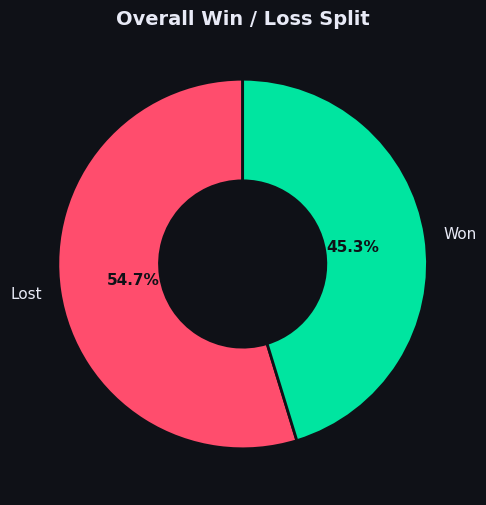

In [12]:
# ── GRAPH: Overall Win / Loss Split ───────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 6), facecolor='#0F1117')

wedges, texts, autotexts = ax.pie(
    counts, labels=counts.index,
    colors=[LOST_COLOR, WON_COLOR],   
    autopct='%1.1f%%', startangle=90,
    wedgeprops=dict(width=0.55, edgecolor='#0F1117', linewidth=2),
    textprops={'color': '#E8EAF6', 'fontsize': 11}
)


for at in autotexts:
    at.set_color('#0F1117')
    at.set_fontweight('bold')

ax.set_title('Overall Win / Loss Split')
plt.savefig('outputs/01_win_loss_split.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()


The overall win rate is **45.26% (2,263 wins out of 5,000 deals)**, while **54.74% of deals are being lost (2,737 deals)**. This confirms the CRO’s concern that win rate is structurally weak, not just fluctuating by chance.

From a revenue impact perspective, even a small improvement here is material. For example, improving win rate from **45% → 50%** on the same pipeline volume would convert ~**250 additional deals**, which is a meaningful revenue uplift without increasing lead volume.

This also establishes a baseline for all downstream analysis:
- Any segment with win rate **below 45%** is underperforming and a candidate for intervention.
- Any segment with win rate **above 45%** represents a best-practice pattern worth scaling across teams or regions.

Action-wise, leadership should avoid defaulting to “increase pipeline volume” as the primary lever. The data suggests the bigger lever is **conversion quality**: fixing loss drivers, qualification gaps, and late-stage friction will likely outperform simply adding more leads.


In [14]:
# ── CALC: Quarterly Win Rate Trend ────────────────────────────────────────────
calc_q_wr = (
    df.groupby('close_quarter')['won']
      .agg(total_deals='count', wins='sum', win_rate_pct=lambda x: round(x.mean() * 100, 2))
      .reset_index()
      .sort_values('close_quarter')
)

print("=== CALC: Quarterly Win Rate Trend ===")
print(calc_q_wr)


=== CALC: Quarterly Win Rate Trend ===
  close_quarter  total_deals  wins  win_rate_pct
0        2023Q1          328   146         44.51
1        2023Q2          973   438         45.02
2        2023Q3         1016   435         42.81
3        2023Q4         1027   488         47.52
4        2024Q1          990   462         46.67
5        2024Q2          637   279         43.80
6        2024Q3           29    15         51.72


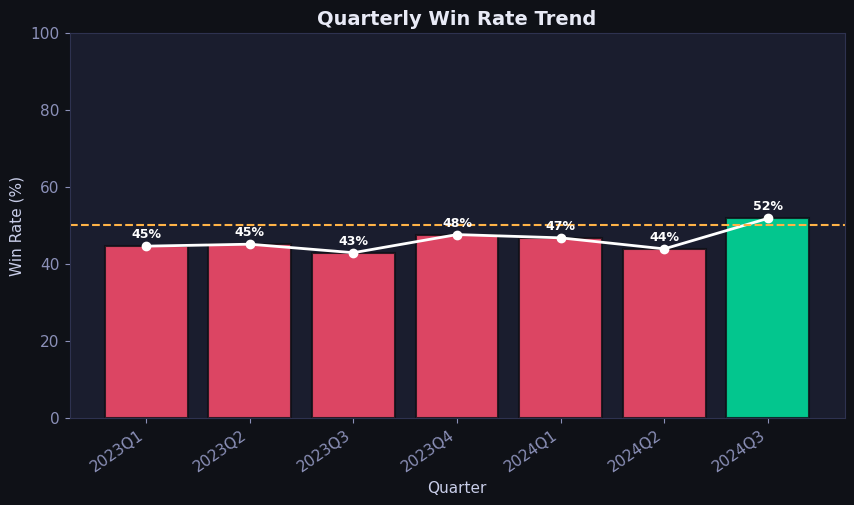

In [15]:
# ── GRAPH: Quarterly Win Rate Trend ───────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5), facecolor='#0F1117')

bars = ax.bar(
    calc_q_wr['close_quarter'], calc_q_wr['win_rate_pct'],
    color=[WON_COLOR if w >= 50 else LOST_COLOR for w in calc_q_wr['win_rate_pct']],
    edgecolor='#0F1117', linewidth=1.5, alpha=0.85
)

ax.plot(calc_q_wr['close_quarter'], calc_q_wr['win_rate_pct'], color='white', marker='o', linewidth=2)
ax.axhline(50, color=ACCENT2, linestyle='--', linewidth=1.5)

for i, row in calc_q_wr.iterrows():
    ax.text(i, row['win_rate_pct'] + 1.5, f"{row['win_rate_pct']:.0f}%",
            ha='center', va='bottom', color='white', fontsize=9, fontweight='bold')

ax.set_title('Quarterly Win Rate Trend')
ax.set_xlabel('Quarter')
ax.set_ylabel('Win Rate (%)')
ax.set_ylim(0, 100)
plt.setp(ax.get_xticklabels(), rotation=35, ha='right')

plt.savefig('outputs/02_quarterly_win_rate.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()


Quarterly win rate fluctuates between **~42.8% and ~47.5%** for most periods, staying **below the 50% baseline in 6 out of 7 quarters**. The weakest quarter is **2023Q3 (42.81%)**, followed by **2024Q2 (43.80%)**, indicating sustained underperformance rather than a one-off dip.

There is a temporary recovery in **2023Q4 (47.52%)** and **2024Q1 (46.67%)**, but the improvement is not durable and drops again in the following quarter. This pattern suggests that any short-term fixes or seasonal effects are not structurally improving conversion.

The apparent spike in **2024Q3 (51.72%)** is based on **very low volume (29 deals)** and should not be treated as a real trend. Small sample sizes can easily create misleading improvements.

From an action standpoint:
- Leadership should avoid reacting to single-quarter spikes and instead focus on **structural drivers** of conversion.
- Quarters with win rate **<45%** should be reviewed for changes in pipeline composition rather than assuming rep performance issues.
- This trend justifies building a **win-rate driver analysis** to identify factors dragging conversion below the 50% threshold across most quarters.
uarters.


In [17]:
# ── CALC: Revenue Won vs Lost per Quarter ─────────────────────────────────────
calc_rev = (
    df.groupby(['close_quarter', 'outcome'])['deal_amount']
      .sum()
      .unstack(fill_value=0)
      .reset_index()
)

calc_rev['won_revenue_m']  = (calc_rev['Won']  / 1e6).round(3)
calc_rev['lost_revenue_m'] = (calc_rev['Lost'] / 1e6).round(3)

print("=== CALC: Revenue Won vs Lost per Quarter ($M) ===")
print(calc_rev[['close_quarter', 'won_revenue_m', 'lost_revenue_m']])


=== CALC: Revenue Won vs Lost per Quarter ($M) ===
outcome close_quarter  won_revenue_m  lost_revenue_m
0              2023Q1          3.565           4.125
1              2023Q2         10.991          13.890
2              2023Q3         12.823          15.077
3              2023Q4         12.715          14.085
4              2024Q1         12.702          13.711
5              2024Q2          7.519           9.490
6              2024Q3          0.275           0.465


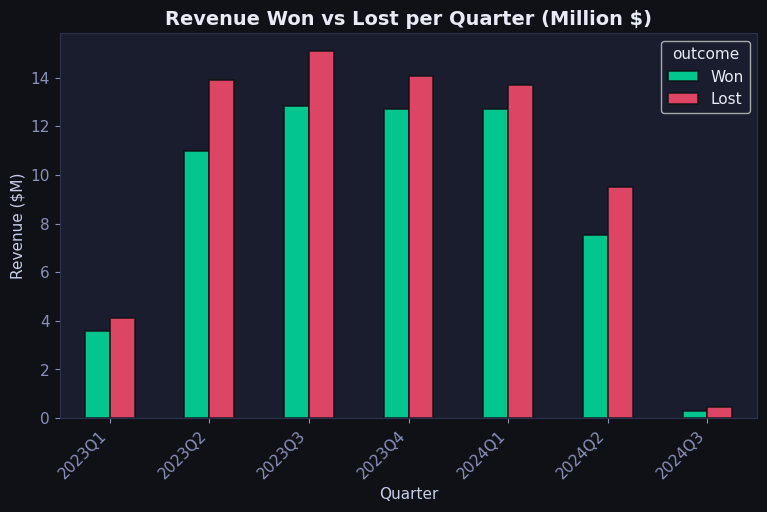

In [18]:
# ── GRAPH: Revenue Won vs Lost per Quarter ────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 5), facecolor='#0F1117')

color_map = {'Won': WON_COLOR, 'Lost': LOST_COLOR}

calc_rev.set_index('close_quarter')[['Won', 'Lost']].div(1e6).plot(
    kind='bar',
    ax=ax,
    color=[color_map['Won'], color_map['Lost']],
    edgecolor='#0F1117',
    linewidth=1.2,
    alpha=0.85
)


ax.set_title('Revenue Won vs Lost per Quarter (Million $)')
ax.set_xlabel('Quarter')
ax.set_ylabel('Revenue ($M)')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.savefig('outputs/03_revenue_won_vs_lost.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()


Across every quarter, **lost revenue exceeds won revenue**, meaning the company is consistently leaving more money on the table than it is closing. For example:
- **2023Q2:** $10.99M won vs **$13.89M lost** (≈ **$2.9M gap**)
  
- **2023Q3:** $12.82M won vs **$15.08M lost** (≈ **$2.25M gap**)

- **2024Q1:** $12.70M won vs **$13.71M lost** (≈ **$1.01M gap**)

This shows the problem is not just about win rate percentage — it is a **revenue efficiency problem**. The organization is spending time and sales capacity on deals that, in aggregate, represent **millions in lost potential revenue each quarter**.

The pattern also indicates that as pipeline volume grows (e.g., 2023Q2–2024Q1), **lost revenue scales alongside won revenue**, suggesting that pipeline quality and late-stage conversion are not improving with scale.

The small numbers in **2024Q3** reflect **very low volume**, so they should not be used to infer performance changes.

From an action standpoint:
- Prioritize fixing loss drivers in **high-ACV segments**, because reducing losses on large deals has outsized revenue impact.
- Introduce stage-level qualification or deal-risk scoring for large opportunities to prevent sales effort being spent on low-probability, high-value deals.
- Track a revenue-focused metric (e.g., *Lost Revenue / Total Pipeline Revenue*) alongside win rate to avoid optimizing conversion % while still leaking revenue.


In [20]:
# ── CALC: Win Rate by Industry ────────────────────────────────────────────────
calc_ind_wr = (
    df.groupby('industry')['won']
      .agg(total_deals='count', wins='sum', win_rate_pct=lambda x: round(x.mean() * 100, 2))
      .reset_index()
      .sort_values('win_rate_pct')
)

print("=== CALC: Win Rate by Industry ===")
print(calc_ind_wr)


=== CALC: Win Rate by Industry ===
     industry  total_deals  wins  win_rate_pct
1      EdTech          992   438         44.15
3  HealthTech         1010   450         44.55
0   Ecommerce         1060   476         44.91
4        SaaS         1001   452         45.15
2     FinTech          937   447         47.71


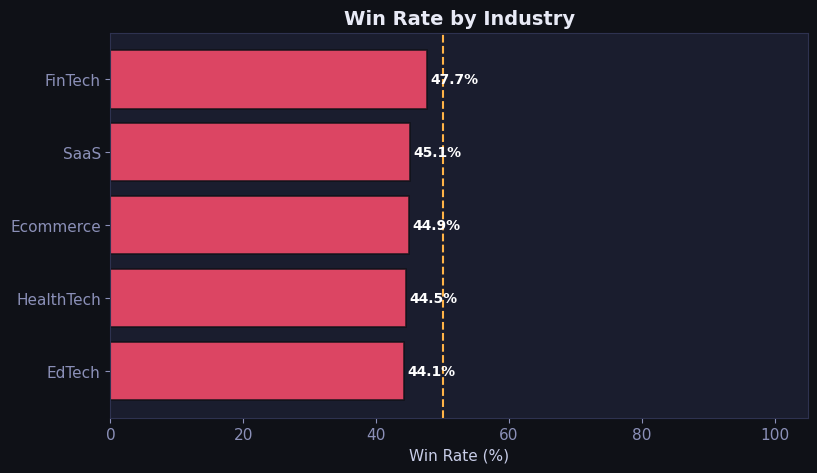

In [21]:
# ── GRAPH: Win Rate by Industry ───────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 5), facecolor='#0F1117')

bars = ax.barh(calc_ind_wr['industry'], calc_ind_wr['win_rate_pct'],
               color=[WON_COLOR if v >= 50 else LOST_COLOR for v in calc_ind_wr['win_rate_pct']],
               edgecolor='#0F1117', linewidth=1.2, alpha=0.85)

for bar, val in zip(bars, calc_ind_wr['win_rate_pct']):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2,
            f'{val:.1f}%', va='center', color='white', fontsize=10, fontweight='bold')

ax.axvline(50, color=ACCENT2, linestyle='--', linewidth=1.5)
ax.set_title('Win Rate by Industry')
ax.set_xlabel('Win Rate (%)')
ax.set_xlim(0, 105)

plt.savefig('outputs/04_win_rate_by_industry.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()


Win rates are **consistently below 50% across all industries**, with a narrow spread from **44.15% (EdTech)** to **47.71% (FinTech)**. This indicates that the win-rate problem is **systemic**, not isolated to a single vertical.

While **FinTech performs relatively better (47.71%)**, it is still below the 50% baseline, so there is no industry where the current sales motion is clearly “working well.” The lowest performers, **EdTech (44.15%)** and **HealthTech (44.55%)**, likely face either weaker product–market fit, tougher competition, or higher buyer friction.

Because differences are modest (≈3.5 pp between best and worst), industry alone is unlikely to be the primary driver of losses. This suggests that **process-level factors** (deal size mix, lead source quality, sales cycle friction, stage progression) are more likely responsible for the depressed win rate.

Action-wise:
- Avoid over-investing in “industry targeting” as the main fix; gains from switching vertical focus will be limited.
- Use FinTech as a relative benchmark to study what is working better (lead sources, deal sizes, sales cycle behavior) and replicate those patterns across other industries.
- Combine industry with other dimensions (deal size bucket × lead source × cycle length) to uncover high-risk combinations rather than treating industry in isolation.


In [23]:
# ── CALC: Win Rate by Region ──────────────────────────────────────────────────
calc_reg_wr = (
    df.groupby('region')['won']
      .agg(total_deals='count', wins='sum', win_rate_pct=lambda x: round(x.mean() * 100, 2))
      .reset_index()
      .sort_values('win_rate_pct')
)

print("=== CALC: Win Rate by Region ===")
print(calc_reg_wr)


=== CALC: Win Rate by Region ===
          region  total_deals  wins  win_rate_pct
3  North America         1239   555         44.79
0           APAC         1242   558         44.93
1         Europe         1233   562         45.58
2          India         1286   588         45.72


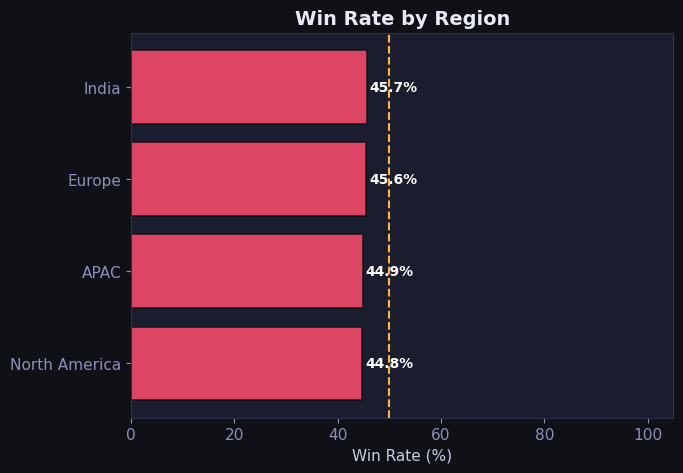

In [24]:
# ── GRAPH: Win Rate by Region ────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 5), facecolor='#0F1117')

bars = ax.barh(calc_reg_wr['region'], calc_reg_wr['win_rate_pct'],
               color=[WON_COLOR if v >= 50 else LOST_COLOR for v in calc_reg_wr['win_rate_pct']],
               edgecolor='#0F1117', linewidth=1.2, alpha=0.85)

for bar, val in zip(bars, calc_reg_wr['win_rate_pct']):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2,
            f'{val:.1f}%', va='center', color='white', fontsize=10, fontweight='bold')

ax.axvline(50, color=ACCENT2, linestyle='--', linewidth=1.5)
ax.set_title('Win Rate by Region')
ax.set_xlabel('Win Rate (%)')
ax.set_xlim(0, 105)

plt.savefig('outputs/05_win_rate_by_region.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()


Win rates are tightly clustered across regions, ranging from **44.79% (North America)** to **45.72% (India)** — a spread of **<1 percentage point**. This indicates that geography is **not a primary driver** of the win-rate decline.

No region crosses the 50% baseline, reinforcing that the issue is **global and systemic**, not localized to a specific market or sales team. The relatively uniform performance also suggests that regional execution differences (e.g., manager quality, territory design) are unlikely to explain most losses.

Because regional variance is minimal, optimizing at the region level will likely deliver **low ROI** compared to targeting process-level drivers (lead source quality, deal size mix, sales cycle friction, stage progression).

Action-wise:
- Avoid region-specific firefighting as the main strategy; the problem is not isolated to one geography.
- Use region primarily for **operational tuning** (staffing, coverage), not as the core lever for improving win rate.
- Focus deeper analysis on dimensions that are more likely to explain variance in outcomes (lead source, deal size bucket, cycle length, stage transitions).


In [26]:
# ── CALC: Deal Volume per Quarter ─────────────────────────────────────────────
calc_vol = (
    df.groupby(['close_quarter', 'outcome'])
      .size()
      .unstack(fill_value=0)
      .reset_index()
)

calc_vol['total_deals'] = calc_vol['Won'] + calc_vol['Lost']

print("=== CALC: Deal Volume per Quarter ===")
print(calc_vol[['close_quarter', 'Won', 'Lost', 'total_deals']])


=== CALC: Deal Volume per Quarter ===
outcome close_quarter  Won  Lost  total_deals
0              2023Q1  146   182          328
1              2023Q2  438   535          973
2              2023Q3  435   581         1016
3              2023Q4  488   539         1027
4              2024Q1  462   528          990
5              2024Q2  279   358          637
6              2024Q3   15    14           29


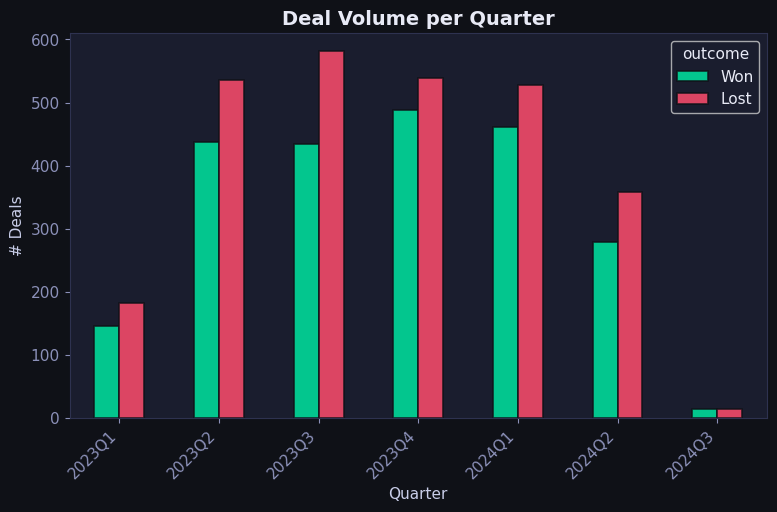

In [27]:
# ── GRAPH: Deal Volume per Quarter ────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 5), facecolor='#0F1117')

calc_vol.set_index('close_quarter')[['Won', 'Lost']].plot(
    kind='bar', ax=ax, color=[WON_COLOR, LOST_COLOR],
    edgecolor='#0F1117', linewidth=1.2, alpha=0.85
)

ax.set_title('Deal Volume per Quarter')
ax.set_xlabel('Quarter')
ax.set_ylabel('# Deals')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.savefig('outputs/06_deal_volume_by_quarter.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()


Pipeline volume is **healthy and stable** across most quarters, ranging from **~970 to ~1,027 deals** between **2023Q2–2024Q1**. This supports the CRO’s observation that the **top-of-funnel and pipeline creation are not the primary problem**.

Despite strong volume, the number of **lost deals consistently exceeds won deals** in every high-volume quarter (e.g., **2023Q3: 581 lost vs 435 won; 2024Q1: 528 lost vs 462 won**). This confirms that the win-rate issue is driven by **conversion efficiency**, not insufficient deal flow.

The sharp drop in **2024Q2 (637 deals)** and especially **2024Q3 (29 deals)** likely reflects partial-quarter data or incomplete ingestion rather than a true collapse in pipeline creation, so these periods should be treated cautiously in trend interpretation.

Action-wise:
- Leadership should avoid investing primarily in lead generation or pipeline expansion as the fix; volume is already sufficient.
- The biggest lever is improving **mid-to-late funnel conversion** (qualification rigor, stage progression, competitive handling, pricing/packaging fit).
- Sales capacity planning should focus on **reducing wasted effort on low-probability deals**, since high volume with low conversion leads to inefficiency and burnout.


---
## Win Rate Deep-Dive by Dimension

In [30]:
calc_industry = (
    df.groupby('industry')['won']
      .agg(total_deals='count', wins='sum', win_rate_pct=lambda x: round(x.mean() * 100, 2))
      .reset_index()
      .sort_values('win_rate_pct')
)

print("=== CALC: Win Rate by Industry ===")
print(calc_industry)


=== CALC: Win Rate by Industry ===
     industry  total_deals  wins  win_rate_pct
1      EdTech          992   438         44.15
3  HealthTech         1010   450         44.55
0   Ecommerce         1060   476         44.91
4        SaaS         1001   452         45.15
2     FinTech          937   447         47.71


In [31]:
calc_region = (
    df.groupby('region')['won']
      .agg(total_deals='count', wins='sum', win_rate_pct=lambda x: round(x.mean() * 100, 2))
      .reset_index()
      .sort_values('win_rate_pct')
)

print("=== CALC: Win Rate by Region ===")
print(calc_region)


=== CALC: Win Rate by Region ===
          region  total_deals  wins  win_rate_pct
3  North America         1239   555         44.79
0           APAC         1242   558         44.93
1         Europe         1233   562         45.58
2          India         1286   588         45.72


In [32]:
calc_product = (
    df.groupby('product_type')['won']
      .agg(total_deals='count', wins='sum', win_rate_pct=lambda x: round(x.mean() * 100, 2))
      .reset_index()
      .sort_values('win_rate_pct')
)

print("=== CALC: Win Rate by Product Type ===")
print(calc_product)


=== CALC: Win Rate by Product Type ===
  product_type  total_deals  wins  win_rate_pct
1   Enterprise         1630   733         44.97
2          Pro         1676   759         45.29
0         Core         1694   771         45.51


In [33]:
calc_lead = (
    df.groupby('lead_source')['won']
      .agg(total_deals='count', wins='sum', win_rate_pct=lambda x: round(x.mean() * 100, 2))
      .reset_index()
      .sort_values('win_rate_pct')
)

print("=== CALC: Win Rate by Lead Source ===")
print(calc_lead)


=== CALC: Win Rate by Lead Source ===
  lead_source  total_deals  wins  win_rate_pct
2     Partner         1240   545         43.95
1    Outbound         1246   567         45.51
3    Referral         1252   570         45.53
0     Inbound         1262   581         46.04


In [34]:
calc_stage = (
    df.groupby('deal_stage')['won']
      .agg(total_deals='count', wins='sum', win_rate_pct=lambda x: round(x.mean() * 100, 2))
      .reset_index()
      .sort_values('win_rate_pct')
)

print("=== CALC: Win Rate by Deal Stage ===")
print(calc_stage)


=== CALC: Win Rate by Deal Stage ===
    deal_stage  total_deals  wins  win_rate_pct
4    Qualified          956   404         42.26
3     Proposal         1009   451         44.70
1         Demo         1043   478         45.83
2  Negotiation          995   464         46.63
0       Closed          997   466         46.74


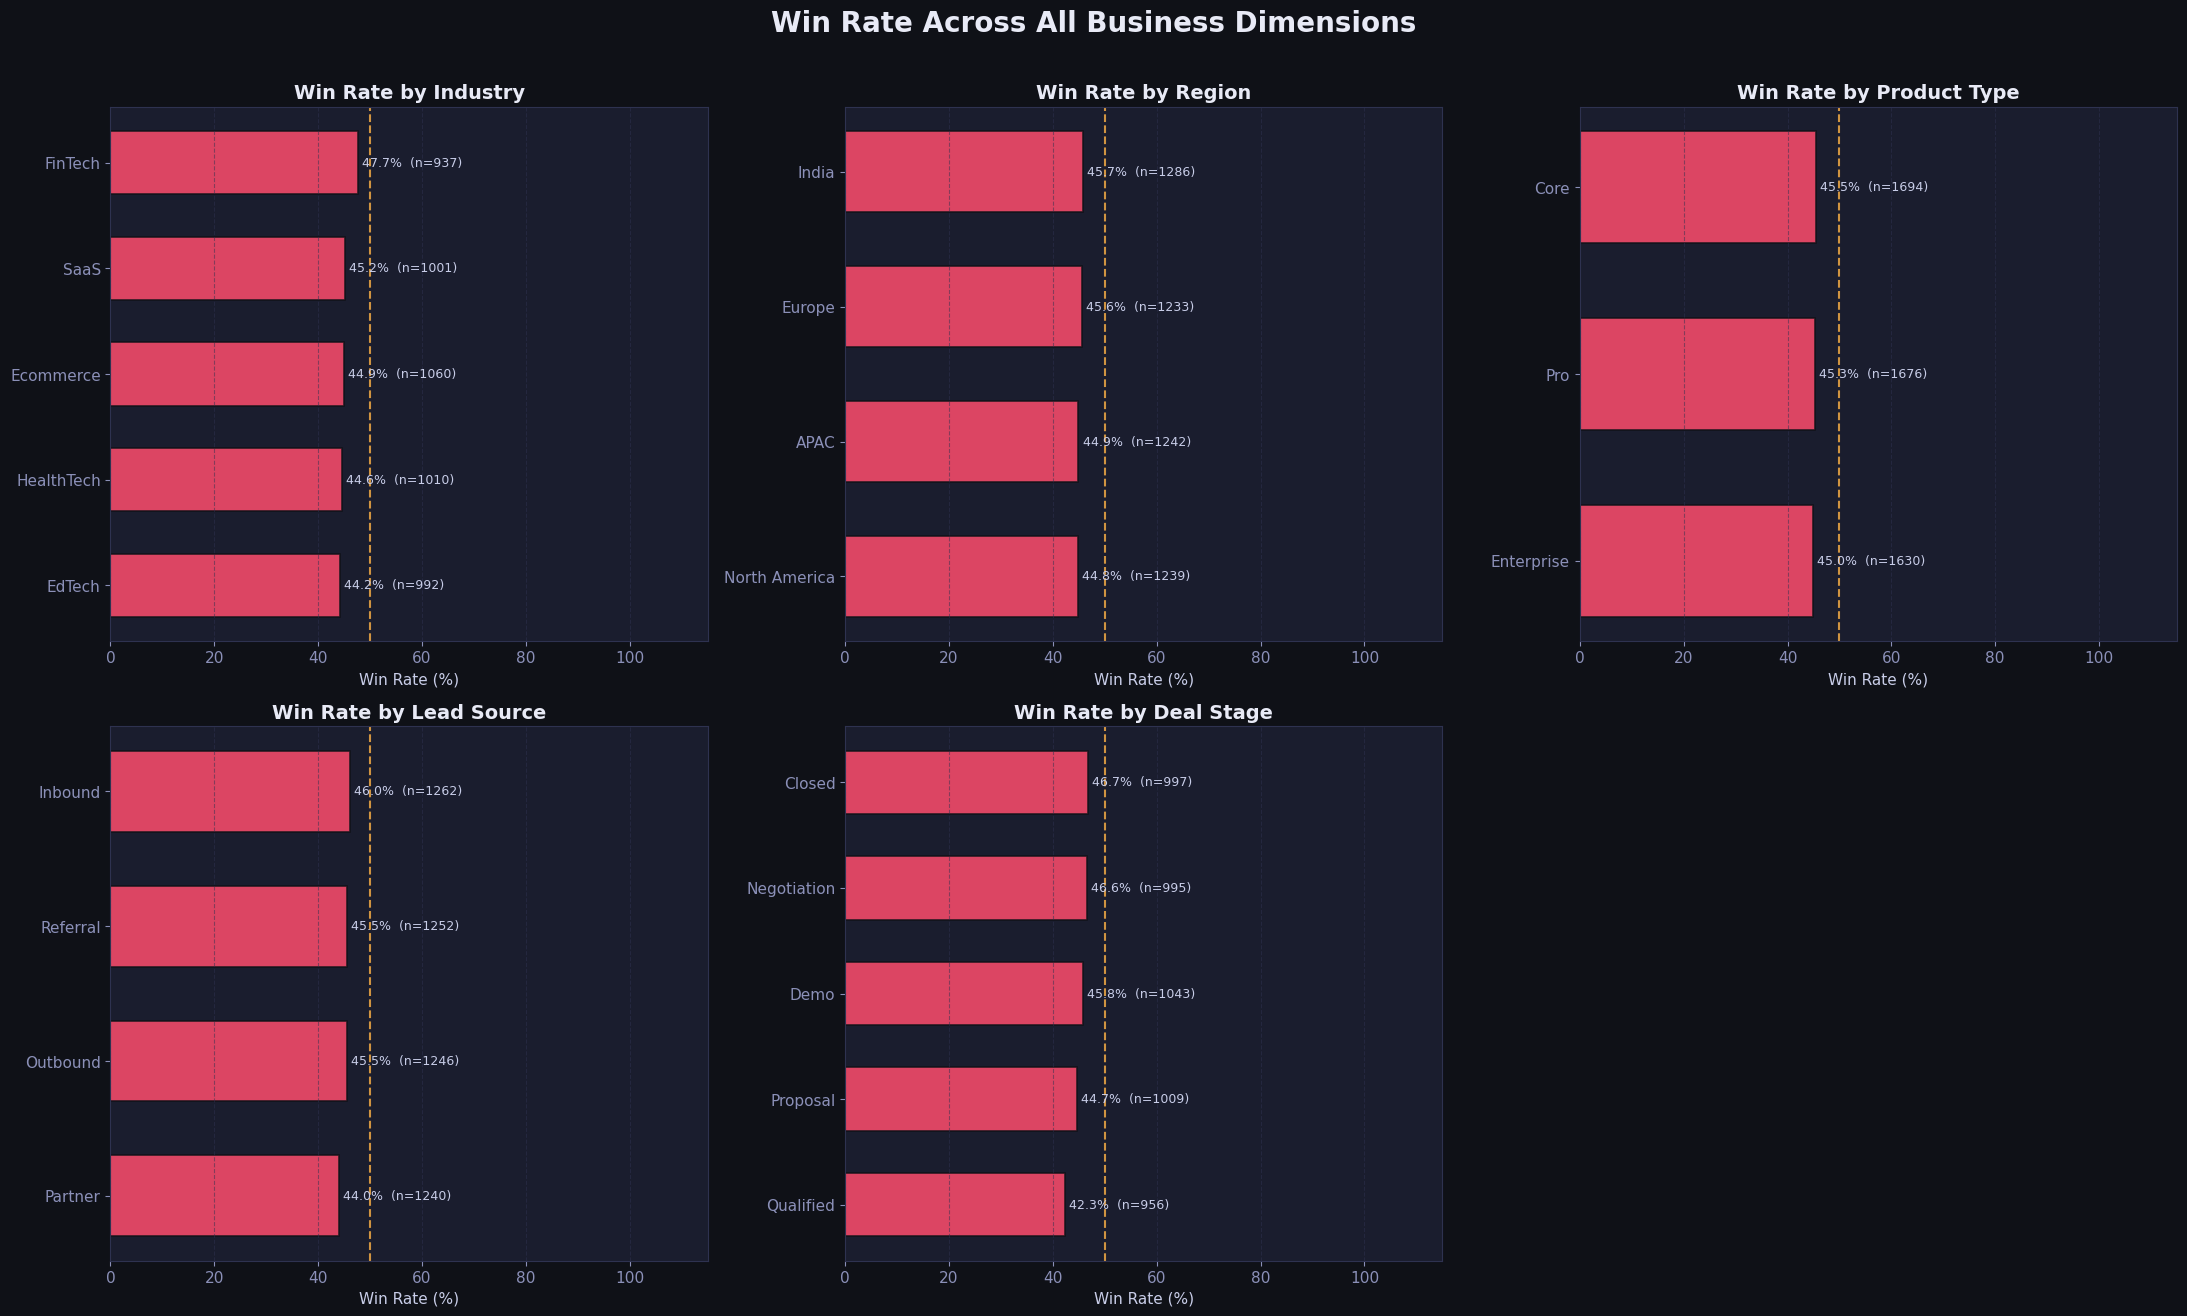

✅ Dimension breakdown saved


In [35]:
# ── GRAPH: Win rate across ALL categorical dimensions ─────────────────────────

dims = ['industry','region','product_type','lead_source','deal_stage']

fig, axes = plt.subplots(2, 3, figsize=(22, 13), facecolor='#0F1117')
fig.suptitle('Win Rate Across All Business Dimensions', 
             fontsize=20, fontweight='bold', color='#E8EAF6', y=1.01)

axes = axes.flatten()

for i, dim in enumerate(dims):
    ax = axes[i]

    stats = (
        df.groupby(dim)['won']
          .agg(total='count', win_rate='mean')
          .reset_index()
    )

    stats['win_rate'] = stats['win_rate'] * 100
    stats = stats.sort_values('win_rate', ascending=True)

    bar_colors = [WON_COLOR if v >= 50 else LOST_COLOR for v in stats['win_rate']]

    bars = ax.barh(
        stats[dim], stats['win_rate'],
        color=bar_colors,
        alpha=0.85,
        edgecolor='#0F1117',
        linewidth=1.2,
        height=0.6
    )

    for j, (_, row) in enumerate(stats.iterrows()):
        ax.text(row['win_rate'] + 0.8, j,
                f"{row['win_rate']:.1f}%  (n={row['total']})",
                va='center', color='#C8CDE8', fontsize=9)

    ax.axvline(50, color=ACCENT2, linestyle='--', linewidth=1.5, alpha=0.8)
    ax.set_xlim(0, 115)
    ax.set_xlabel('Win Rate (%)')
    ax.set_title(f'Win Rate by {dim.replace("_"," ").title()}')
    ax.grid(axis='x', zorder=0)

# hide unused axis
axes[5].set_visible(False)

plt.tight_layout()
plt.savefig('outputs/02_winrate_by_dimension.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()

print('✅ Dimension breakdown saved')


Across all categorical dimensions (industry, region, product type, lead source, deal stage), **win rates cluster tightly between ~42% and ~48%**, and **no segment crosses the 50% baseline**. This confirms the win-rate problem is **systemic**, not driven by a single market, product, or channel.

Where the losses concentrate:
- **Deal stage:** The largest drop-off is early-to-mid funnel — **Qualified (42.26%)** and **Proposal (44.70%)** underperform relative to later stages (**Negotiation ~46.63%, Closed ~46.74%**). This points to **qualification rigor and early-stage deal quality** as major leak points.
- **Lead source:** **Partner leads underperform (43.95%)** relative to Inbound (46.04%). This suggests partner-sourced deals may be lower intent or weaker fit, and need tighter qualification or different enablement.
- **Industry & region:** Differences are small (≈3 pp across industries; <1 pp across regions), indicating these are **not primary drivers** of the low win rate.
- **Product type:** Core, Pro, and Enterprise are tightly clustered (~45–46%), so product mix alone does not explain losses.

Business takeaway:
- The problem is not “we sell to the wrong industry/region/product.” The problem is **process quality and deal selection**, especially **early-stage qualification and channel quality**.
- Because variance within single dimensions is small, the real signal likely sits in **combinations** (e.g., Partner × Enterprise × Long sales cycle), not in any one dimension alone.

Action-wise:
- Tighten **qualification criteria** at the Qualified → Proposal transition; introduce mandatory fit checks (ICP match, budget authority, timeline).
- Add **stricter gating or enablement for Partner leads** (minimum intent signals, co-selling playbooks).
- Shift analysis and tooling toward **multi-factor risk patterns** (e.g., long cycle + large ACV + partner-sourced) rather than optimizing any single segment in isolation.


---
##  Insight — Win Rate Trend Over Quarters (Industry × Time Heatmap)

In [38]:
# ── CALC: Industry Win Rate by Quarter ────────────────────────────────────────
calc_ind_q_wr = (
    df.pivot_table(
        index='industry',
        columns='close_quarter',
        values='won',
        aggfunc='mean'
    ) * 100
)

calc_ind_q_cnt = (
    df.pivot_table(
        index='industry',
        columns='close_quarter',
        values='won',
        aggfunc='count'
    )
)

print("=== CALC: Industry Win Rate by Quarter (Win %) ===")
print(calc_ind_q_wr.round(2).to_string())

print("\n=== CALC: Industry Deal Count by Quarter (n) ===")
print(calc_ind_q_cnt.to_string())


=== CALC: Industry Win Rate by Quarter (Win %) ===
close_quarter  2023Q1  2023Q2  2023Q3  2023Q4  2024Q1  2024Q2  2024Q3
industry                                                             
Ecommerce       45.45   43.75   43.89   45.41   47.83   41.88   57.14
EdTech          50.72   46.28   39.70   45.69   44.33   39.53   85.71
FinTech         40.68   44.94   48.94   51.05   50.79   44.09   25.00
HealthTech      43.84   42.93   38.50   50.23   45.64   46.15    0.00
SaaS            40.98   47.75   42.99   45.37   44.85   47.01   50.00

=== CALC: Industry Deal Count by Quarter (n) ===
close_quarter  2023Q1  2023Q2  2023Q3  2023Q4  2024Q1  2024Q2  2024Q3
industry                                                             
Ecommerce          66     224     221     218     207     117       7
EdTech             69     188     199     197     203     129       7
FinTech            59     178     188     190     191     127       4
HealthTech         73     205     187     217     195     1

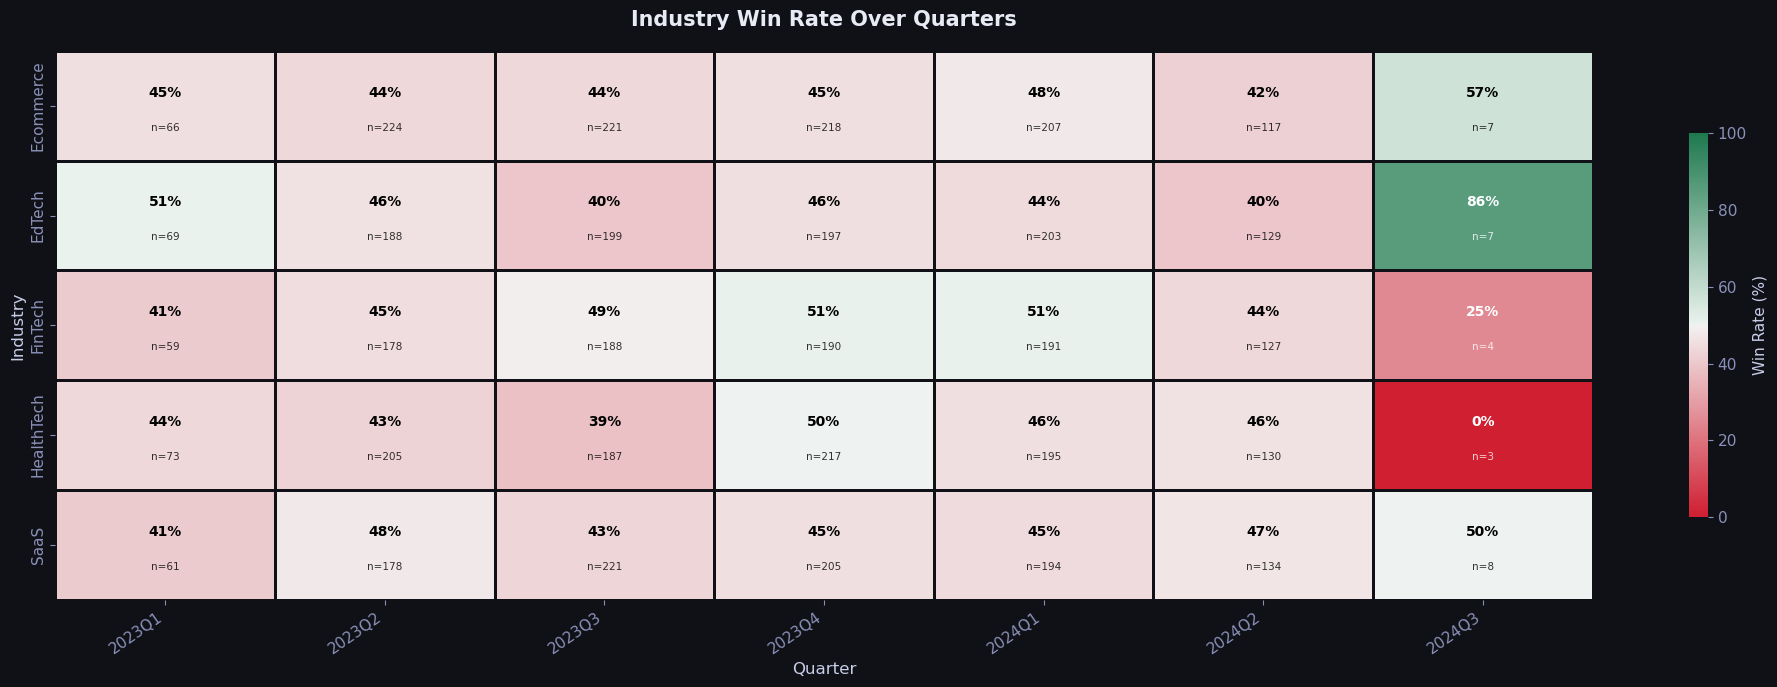

✅ Industry × Quarter heatmap saved


In [39]:
# ── GRAPH: Industry Win Rate Over Quarters — Heatmap ──────────────────────────

pivot = calc_ind_q_wr
pivot_count = calc_ind_q_cnt

fig, ax = plt.subplots(figsize=(20, 7), facecolor='#0F1117')
ax.set_facecolor('#1A1D2E')

cmap = sns.diverging_palette(10, 145, s=90, l=45, as_cmap=True)

sns.heatmap(
    pivot,
    ax=ax,
    cmap=cmap,
    center=50,
    vmin=0,
    vmax=100,
    linewidths=2,
    linecolor='#0F1117',
    annot=False,
    cbar_kws={'shrink': 0.7, 'label': 'Win Rate (%)'}
)

for r_idx, industry in enumerate(pivot.index):
    for c_idx, quarter in enumerate(pivot.columns):
        wr  = pivot.loc[industry, quarter]
        cnt = pivot_count.loc[industry, quarter] if not pd.isna(pivot_count.loc[industry, quarter]) else 0

        if not pd.isna(wr):
            txt_color = 'black' if 35 < wr < 75 else 'white'
            ax.text(c_idx + 0.5, r_idx + 0.38, f'{wr:.0f}%',
                    ha='center', va='center', color=txt_color,
                    fontsize=10, fontweight='bold')
            ax.text(c_idx + 0.5, r_idx + 0.70, f'n={int(cnt)}',
                    ha='center', va='center', color=txt_color, fontsize=7.5, alpha=0.8)

ax.set_title('Industry Win Rate Over Quarters', fontsize=15, pad=18)
ax.set_xlabel('Quarter', fontsize=12)
ax.set_ylabel('Industry', fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=35, ha='right')

plt.tight_layout()
plt.savefig('outputs/03_industry_quarter_heatmap.png', dpi=150,
            bbox_inches='tight', facecolor='#0F1117')
plt.show()

print('✅ Industry × Quarter heatmap saved')


Win rate varies more **over time within each industry** than it does **between industries in aggregate**, which explains why industry-level averages looked flat earlier. For example:
- **EdTech** drops sharply in **2023Q3 (39.70%)** and **2024Q2 (39.53%)**, indicating periods of acute underperformance.
- **HealthTech** rebounds in **2023Q4 (50.23%)** but fails to sustain that improvement in subsequent quarters.
- **FinTech** crosses 50% in **2023Q4 (51.05%)** and **2024Q1 (50.79%)**, but falls back in **2024Q2 (44.09%)**, showing volatility rather than durable improvement.

The apparent spikes in **2024Q3** (e.g., EdTech 85.71%, Ecommerce 57.14%) are driven by **very low deal counts (n ≤ 8)** and should be treated as noise rather than true performance shifts.

This pattern suggests that win-rate degradation is driven by **quarter-specific changes in pipeline mix or execution** (e.g., campaign mix, lead-source quality, deal size distribution, competitive pressure), not stable industry characteristics.

Action-wise:
- Treat “good quarters” within industries as **case studies** to reverse-engineer what changed (lead mix, deal sizes, stage progression speed) and attempt to replicate those conditions.
- Avoid making strategic bets on industries based on single-quarter improvements; require **multi-quarter confirmation** with sufficient volume.
- Use this view to trigger **quarterly diagnostics**: when an industry dips below ~43–44% in a quarter, automatically audit pipeline composition and early-stage qualification quality.


---
## 5. Insight 2 — Lead Source Quality Degradation

In [42]:
# ── CALC A: Lead Source Win Rate / Volume / Avg Deal ──────────────────────────
calc_ls_stats = (
    df.groupby('lead_source')
      .agg(
          win_rate_pct=('won', lambda x: round(x.mean() * 100, 2)),
          total_deals=('won', 'count'),
          avg_deal_amount=('deal_amount', 'mean')
      )
      .reset_index()
      .sort_values('win_rate_pct', ascending=False)
)

print("=== CALC A: Lead Source Win Rate / Volume / Avg Deal ===")
print(calc_ls_stats.round(2).to_string(index=False))


=== CALC A: Lead Source Win Rate / Volume / Avg Deal ===
lead_source  win_rate_pct  total_deals  avg_deal_amount
    Inbound         46.04         1262         27041.87
   Referral         45.53         1252         26261.35
   Outbound         45.51         1246         25963.35
    Partner         43.95         1240         25867.81


In [43]:
# ── CALC B: Lead Source Volume Over Time ──────────────────────────────────────
calc_ls_trend = (
    df.groupby(['close_quarter', 'lead_source'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

print("=== CALC B: Lead Source Volume Over Time ===")
print(calc_ls_trend.to_string())


=== CALC B: Lead Source Volume Over Time ===
lead_source    Inbound  Outbound  Partner  Referral
close_quarter                                      
2023Q1              71        74       85        98
2023Q2             247       232      258       236
2023Q3             257       261      245       253
2023Q4             257       237      286       247
2024Q1             254       260      235       241
2024Q2             168       174      129       166
2024Q3               8         8        2        11


In [44]:
# ── CALC C: Avg Deal Size by Lead Source (Won vs Lost) ─────────────────────────
calc_ls_deal = (
    df.groupby(['lead_source', 'outcome'])['deal_amount']
      .mean()
      .unstack()
      .reset_index()
)

calc_ls_deal['Won_K']  = (calc_ls_deal['Won']  / 1000).round(2)
calc_ls_deal['Lost_K'] = (calc_ls_deal['Lost'] / 1000).round(2)

print("=== CALC C: Avg Deal Size by Lead Source (K$) ===")
print(calc_ls_deal[['lead_source', 'Won_K', 'Lost_K']].to_string(index=False))


=== CALC C: Avg Deal Size by Lead Source (K$) ===
lead_source  Won_K  Lost_K
    Inbound  27.74   26.45
   Outbound  24.85   26.89
    Partner  25.93   25.82
   Referral  28.51   24.38


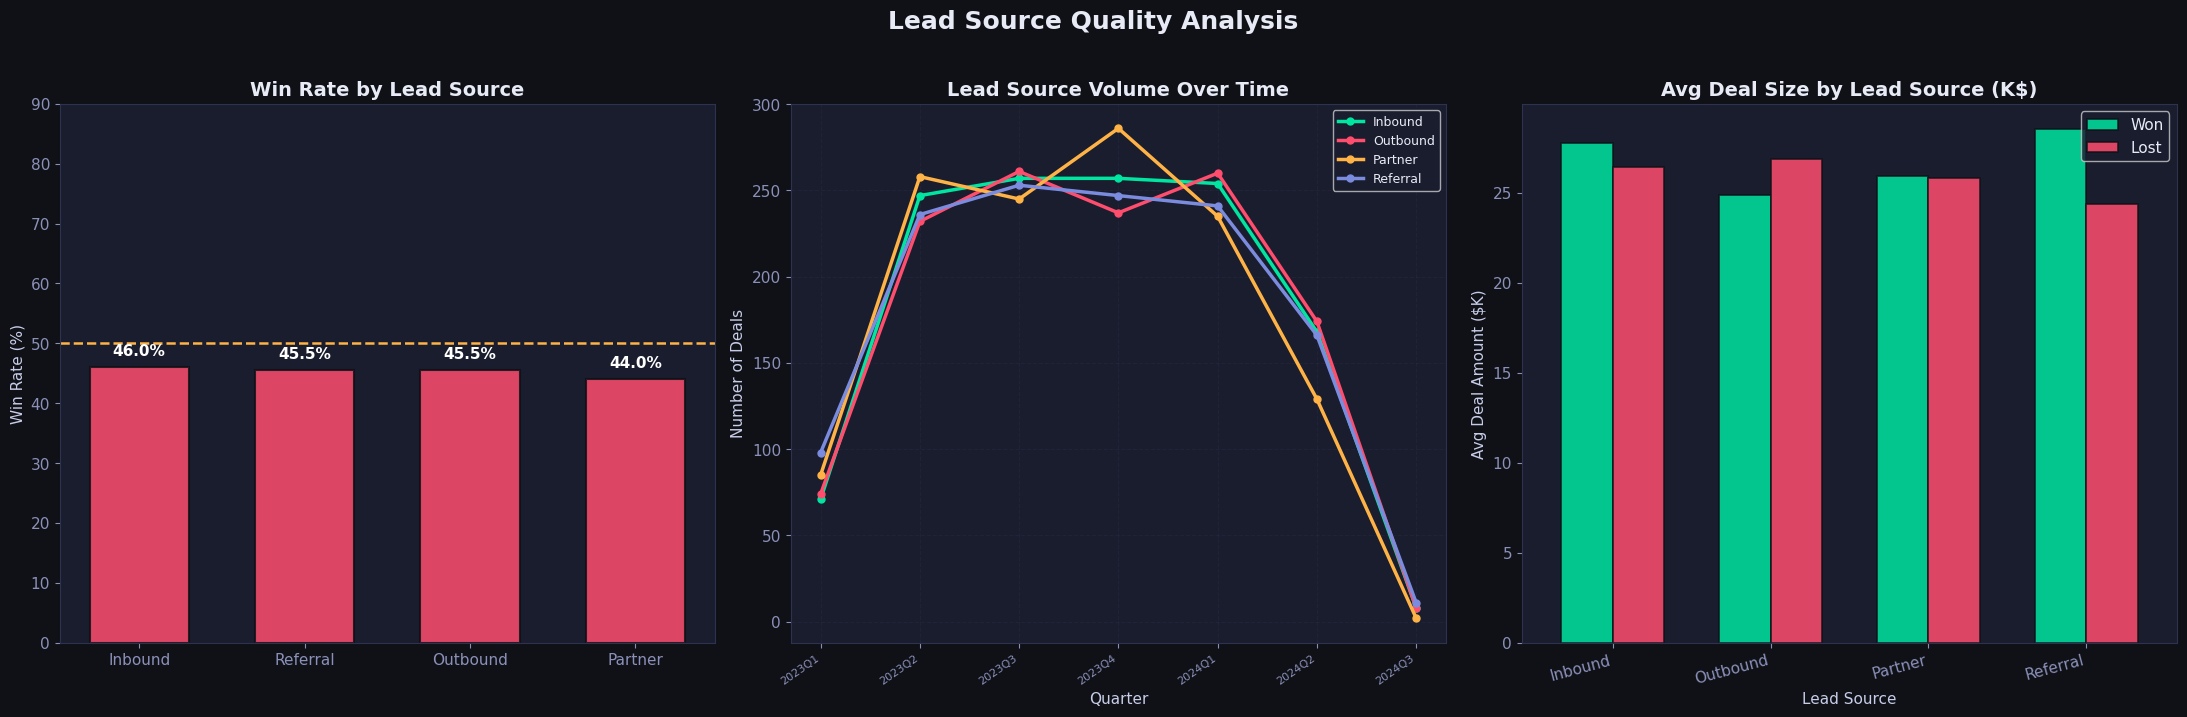

✅ Lead source analysis saved


In [45]:
# ── GRAPH: Lead Source Quality Analysis ───────────────────────────────────────

fig, axes = plt.subplots(1, 3, figsize=(22, 7), facecolor='#0F1117')
fig.suptitle('Lead Source Quality Analysis',
             fontsize=18, fontweight='bold', color='#E8EAF6', y=1.02)

# Sub-plot A: Win rate per lead source
ax = axes[0]

ls_stats = calc_ls_stats.copy()

bar_colors = [WON_COLOR if v >= 50 else LOST_COLOR for v in ls_stats['win_rate_pct']]

bars = ax.bar(ls_stats['lead_source'], ls_stats['win_rate_pct'],
              color=bar_colors, alpha=0.85, edgecolor='#0F1117',
              linewidth=1.5, width=0.6)

ax.axhline(50, color=ACCENT2, linestyle='--', linewidth=1.8)

for bar, val in zip(bars, ls_stats['win_rate_pct']):
    ax.text(bar.get_x() + bar.get_width()/2, val + 1.5,
            f'{val:.1f}%', ha='center', va='bottom',
            color='white', fontsize=11, fontweight='bold')

ax.set_title('Win Rate by Lead Source')
ax.set_ylabel('Win Rate (%)')
ax.set_ylim(0, 90)

# Sub-plot B: Lead source volume trend over quarters
ax2 = axes[1]

ls_trend = calc_ls_trend.copy()
colors_map = {'Inbound': WON_COLOR, 'Referral': ACCENT,
              'Outbound': LOST_COLOR, 'Partner': ACCENT2}

for col in ls_trend.columns:
    ax2.plot(ls_trend.index, ls_trend[col], marker='o', linewidth=2.5,
             color=colors_map.get(col, 'white'), label=col, markersize=5)

ax2.set_title('Lead Source Volume Over Time')
ax2.set_xlabel('Quarter')
ax2.set_ylabel('Number of Deals')
ax2.legend(fontsize=9)
plt.setp(ax2.get_xticklabels(), rotation=35, ha='right', fontsize=8)
ax2.grid(True, alpha=0.3)

# Sub-plot C: Avg deal size per lead source, split won/lost
ax3 = axes[2]

calc_ls_deal_plot = calc_ls_deal.set_index('lead_source')[['Won_K', 'Lost_K']]
calc_ls_deal_plot.plot(kind='bar', ax=ax3,
                       color=[WON_COLOR, LOST_COLOR],
                       edgecolor='#0F1117', linewidth=1.2,
                       alpha=0.85, width=0.65)

ax3.set_title('Avg Deal Size by Lead Source (K$)')
ax3.set_xlabel('Lead Source')
ax3.set_ylabel('Avg Deal Amount ($K)')
ax3.legend(['Won', 'Lost'])
plt.setp(ax3.get_xticklabels(), rotation=15, ha='right')

plt.tight_layout()
plt.savefig('outputs/04_lead_source_quality.png', dpi=150,
            bbox_inches='tight', facecolor='#0F1117')
plt.show()

print('✅ Lead source analysis saved')


Lead sources show a clear quality gradient. **Inbound performs best (46.04%)**, while **Partner is the weakest channel (43.95%)**. The spread is modest (around 2.1 pp), but at scale this translates into a large number of preventable losses given similar volumes across sources (~1.2–1.26k deals each).

Volume trends show that **Partner volume grows in 2023Q4 (286 deals)** while being the lowest-converting channel. This indicates a **quality–quantity tradeoff**: pipeline growth is being fueled by a channel that converts worse, which mechanically drags overall win rate down.

Deal size does not explain the conversion gap:
- **Outbound** loses larger deals on average than it wins (**$26.9K lost vs $24.9K won**), indicating weak qualification or competitive pressure in outbound motions.
- **Referral** wins larger deals than it loses (**$28.5K won vs $24.4K lost**), suggesting referrals are higher-intent and better qualified.
- **Partner** has similar deal sizes for wins and losses (~$25.9K vs ~$25.8K), so the lower win rate reflects **fit/enablement issues**, not deal economics.

Business takeaway:
- The win-rate decline is partly driven by **pipeline mix shifting toward lower-quality sources**, especially Partner and Outbound.
- Improving lead quality will likely outperform simply adding more leads.

Action-wise:
- Tighten **qualification gates for Partner-sourced deals** (minimum ICP match, buyer role, problem urgency).
- Invest more in **Referral and Inbound** motions (incentives, content, conversion optimization), since they convert better and win larger deals.
- Add source-aware scoring in the decision engine so Partner/Outbound deals require stronger evidence before advancing stages.


---
## 6. Insight 3 — Sales Cycle Length as a Loss Predictor

In [48]:
# ── CALC A: Sales Cycle Distribution (Won vs Lost) ────────────────────────────
won_days  = df.loc[df['won'] == 1, 'sales_cycle_days']
lost_days = df.loc[df['won'] == 0, 'sales_cycle_days']

calc_cycle_dist = pd.DataFrame({
    'metric': ['won_mean_days', 'lost_mean_days', 'won_median_days', 'lost_median_days',
               'won_count', 'lost_count'],
    'value': [
        round(won_days.mean(), 2),
        round(lost_days.mean(), 2),
        round(won_days.median(), 2),
        round(lost_days.median(), 2),
        won_days.shape[0],
        lost_days.shape[0]
    ]
})

print("=== CALC A: Sales Cycle Distribution (Won vs Lost) ===")
print(calc_cycle_dist.to_string(index=False))


=== CALC A: Sales Cycle Distribution (Won vs Lost) ===
          metric   value
   won_mean_days   63.17
  lost_mean_days   64.23
 won_median_days   63.00
lost_median_days   64.00
       won_count 2263.00
      lost_count 2737.00


In [49]:
# ── CALC B: Median Sales Cycle by Industry (Won vs Lost) ───────────────────────
calc_cycle_industry = (
    df.groupby(['industry', 'outcome'])['sales_cycle_days']
      .median()
      .unstack()
      .reset_index()
)

print("=== CALC B: Median Sales Cycle by Industry (Won vs Lost) ===")
print(calc_cycle_industry.to_string(index=False))


=== CALC B: Median Sales Cycle by Industry (Won vs Lost) ===
  industry  Lost  Won
 Ecommerce  66.0 62.0
    EdTech  61.5 61.5
   FinTech  65.5 64.0
HealthTech  64.0 63.5
      SaaS  64.0 65.5


In [50]:
# ── CALC C: Deal Size vs Sales Cycle (Trend Line Coefficients) ─────────────────
calc_scatter_coeffs = {}

for outcome_label, outcome_val in [('Won', 1), ('Lost', 0)]:
    sub = df[df['won'] == outcome_val]
    slope, intercept = np.polyfit(sub['sales_cycle_days'], sub['deal_amount'], 1)
    calc_scatter_coeffs[outcome_label] = {
        'slope': round(slope, 4),
        'intercept': round(intercept, 2),
        'n_points': sub.shape[0]
    }

calc_scatter_coeffs_df = pd.DataFrame(calc_scatter_coeffs).T.reset_index().rename(columns={'index':'outcome'})

print("=== CALC C: Deal Size vs Cycle Length (Linear Trend Coefficients) ===")
print(calc_scatter_coeffs_df.to_string(index=False))


=== CALC C: Deal Size vs Cycle Length (Linear Trend Coefficients) ===
outcome   slope  intercept  n_points
    Won 14.1402   25880.59    2263.0
   Lost 20.5219   24565.39    2737.0


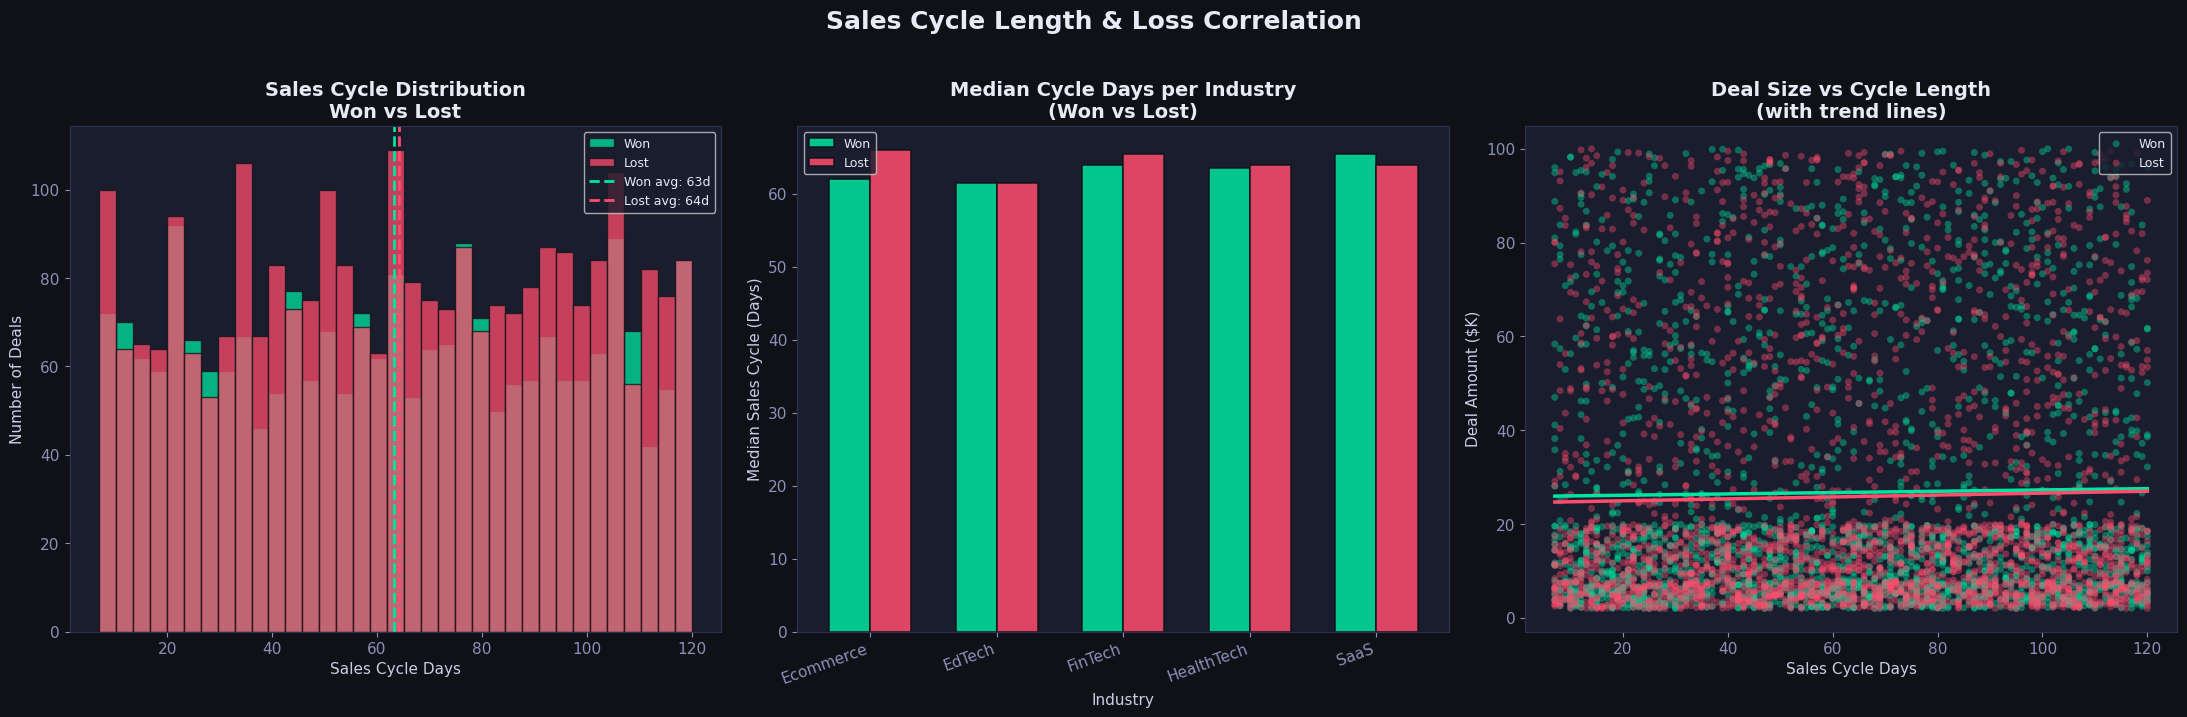

✅ Sales cycle analysis saved


In [51]:
# ── GRAPH: Sales Cycle Length & Loss Correlation ──────────────────────────────

fig, axes = plt.subplots(1, 3, figsize=(22, 7), facecolor='#0F1117')
fig.suptitle('Sales Cycle Length & Loss Correlation',
             fontsize=18, fontweight='bold', color='#E8EAF6', y=1.02)

# Sub-plot A: Distribution of cycle days — Won vs Lost
ax = axes[0]

ax.hist(won_days,  bins=35, alpha=0.75, color=WON_COLOR,  label='Won',  edgecolor='#0F1117')
ax.hist(lost_days, bins=35, alpha=0.75, color=LOST_COLOR, label='Lost', edgecolor='#0F1117')

ax.axvline(won_days.mean(),  color=WON_COLOR,  linestyle='--',
           linewidth=2, label=f'Won avg: {won_days.mean():.0f}d')
ax.axvline(lost_days.mean(), color=LOST_COLOR, linestyle='--',
           linewidth=2, label=f'Lost avg: {lost_days.mean():.0f}d')

ax.set_title('Sales Cycle Distribution\nWon vs Lost')
ax.set_xlabel('Sales Cycle Days')
ax.set_ylabel('Number of Deals')
ax.legend(fontsize=9)

# Sub-plot B: Median cycle days per industry, Won vs Lost
ax2 = axes[1]

calc_cycle_industry.set_index('industry')[['Won', 'Lost']].plot(
    kind='bar', ax=ax2,
    color=[WON_COLOR, LOST_COLOR],
    edgecolor='#0F1117', linewidth=1.2,
    alpha=0.85, width=0.65
)

ax2.set_title('Median Cycle Days per Industry\n(Won vs Lost)')
ax2.set_xlabel('Industry')
ax2.set_ylabel('Median Sales Cycle (Days)')
ax2.legend(['Won', 'Lost'], fontsize=9)
plt.setp(ax2.get_xticklabels(), rotation=20, ha='right')

# Sub-plot C: Deal amount vs cycle days scatter + trend
ax3 = axes[2]

for outcome, color, label in [(1, WON_COLOR, 'Won'), (0, LOST_COLOR, 'Lost')]:
    sub = df[df['won'] == outcome]
    ax3.scatter(sub['sales_cycle_days'], sub['deal_amount'] / 1000,
                c=color, alpha=0.4, s=25, label=label, edgecolors='none')

for outcome, color in [(1, WON_COLOR), (0, LOST_COLOR)]:
    sub = df[df['won'] == outcome]
    z   = np.polyfit(sub['sales_cycle_days'], sub['deal_amount'], 1)
    p   = np.poly1d(z)
    xs  = np.linspace(sub['sales_cycle_days'].min(), sub['sales_cycle_days'].max(), 100)
    ax3.plot(xs, p(xs) / 1000, color=color, linewidth=2.5)

ax3.set_title('Deal Size vs Cycle Length\n(with trend lines)')
ax3.set_xlabel('Sales Cycle Days')
ax3.set_ylabel('Deal Amount ($K)')
ax3.legend(fontsize=9)

plt.tight_layout()
plt.savefig('outputs/05_sales_cycle_correlation.png', dpi=150,
            bbox_inches='tight', facecolor='#0F1117')
plt.show()

print('✅ Sales cycle analysis saved')


Overall sales cycle length is **nearly identical for wins and losses** (mean: **63.2d won vs 64.2d lost**; median: **63d vs 64d**), so cycle length alone is **not a strong global predictor** of outcome. This means “longer cycles = bad deals” is too simplistic as a blanket rule.

However, when broken down by industry, patterns diverge:
- **Ecommerce:** lost deals take longer than won (**66d vs 62d**), indicating late-stage friction or competitive stalls are correlated with loss.
- **SaaS:** won deals are slightly longer than lost (**65.5d vs 64d**), suggesting complex wins that take longer to close but still convert.
- **EdTech:** medians are identical for wins and losses (61.5d), so cycle length carries little signal there.

Deal size interacts with cycle length differently for wins vs losses. The slope of deal size vs cycle length is steeper for **Lost (≈20.5 per day)** than for **Won (≈14.1 per day)**, implying that **large deals that drag on are more likely to be lost**. In other words, as cycle length increases, high-ACV deals disproportionately end up lost.

Business takeaway:
- Sales cycle length becomes a **risk signal when combined with deal size and industry**, not in isolation.
- Long-running **large deals** deserve proactive risk management.

Action-wise:
- Introduce a **cycle-length risk threshold by deal size** (e.g., Enterprise deals > X days trigger exec review or deal coaching).
- Add automated alerts for **stalled deals** (no stage movement for N days), especially for high-ACV opportunities.
- Coach reps on late-stage deal acceleration in industries where longer cycles correlate with loss (e.g., Ecommerce).


---
##  Custom Metric — Deal Velocity Efficiency Score (DVES)

In [55]:
# ── CALC 0: Compute DVES ───────────────────────────────────────────────────────
df['dves'] = df['deal_amount'] / df['sales_cycle_days'].replace(0, np.nan)

print("=== CALC 0: DVES Computed ===")
print(df['dves'].describe().round(2).to_string())


=== CALC 0: DVES Computed ===
count     5000.00
mean       657.82
std       1162.96
min         17.21
25%        110.33
50%        261.50
75%        753.68
max      13715.86


In [56]:
# ── CALC A: DVES Distribution (Won vs Lost) ────────────────────────────────────
won_dves  = df.loc[df['won'] == 1, 'dves'].dropna()
lost_dves = df.loc[df['won'] == 0, 'dves'].dropna()

calc_dves_dist = pd.DataFrame({
    'metric': [
        'won_median_dves', 'lost_median_dves',
        'won_mean_dves', 'lost_mean_dves',
        'won_count', 'lost_count'
    ],
    'value': [
        round(won_dves.median(), 2),
        round(lost_dves.median(), 2),
        round(won_dves.mean(), 2),
        round(lost_dves.mean(), 2),
        won_dves.shape[0],
        lost_dves.shape[0]
    ]
})

print("=== CALC A: DVES Distribution (Won vs Lost) ===")
print(calc_dves_dist.to_string(index=False))


=== CALC A: DVES Distribution (Won vs Lost) ===
          metric   value
 won_median_dves  278.70
lost_median_dves  248.41
   won_mean_dves  690.01
  lost_mean_dves  631.21
       won_count 2263.00
      lost_count 2737.00


In [57]:
# ── CALC B: Median DVES by Industry (Won vs Lost) ──────────────────────────────
calc_dves_ind = (
    df.groupby(['industry', 'outcome'])['dves']
      .median()
      .unstack()
      .reset_index()
)

print("=== CALC B: Median DVES by Industry (Won vs Lost) ===")
print(calc_dves_ind.round(2).to_string(index=False))


=== CALC B: Median DVES by Industry (Won vs Lost) ===
  industry   Lost    Won
 Ecommerce 243.94 311.14
    EdTech 280.10 292.14
   FinTech 262.12 268.53
HealthTech 232.46 291.96
      SaaS 246.59 253.30


In [58]:
# ── CALC C: Median DVES by Sales Rep (Top N) ───────────────────────────────────
rep_dves = df.groupby('sales_rep_id')['dves'].median().sort_values(ascending=False)

top_n = 15
calc_rep_dves_top = rep_dves.head(top_n).reset_index()
calc_rep_dves_top.columns = ['sales_rep_id', 'median_dves']

calc_rep_dves_median = rep_dves.median()

print("=== CALC C: Median DVES by Sales Rep (Top N) ===")
print(calc_rep_dves_top.round(2).to_string(index=False))
print(f"\nOverall median DVES across reps: {calc_rep_dves_median:.2f}")


=== CALC C: Median DVES by Sales Rep (Top N) ===
sales_rep_id  median_dves
       rep_2       365.21
      rep_12       359.28
      rep_20       342.87
      rep_11       342.85
      rep_17       320.57
      rep_25       299.33
       rep_7       283.34
      rep_14       273.31
       rep_6       272.59
       rep_3       268.29
      rep_21       263.49
       rep_5       262.19
      rep_18       252.71
      rep_23       245.27
      rep_10       242.78

Overall median DVES across reps: 252.71


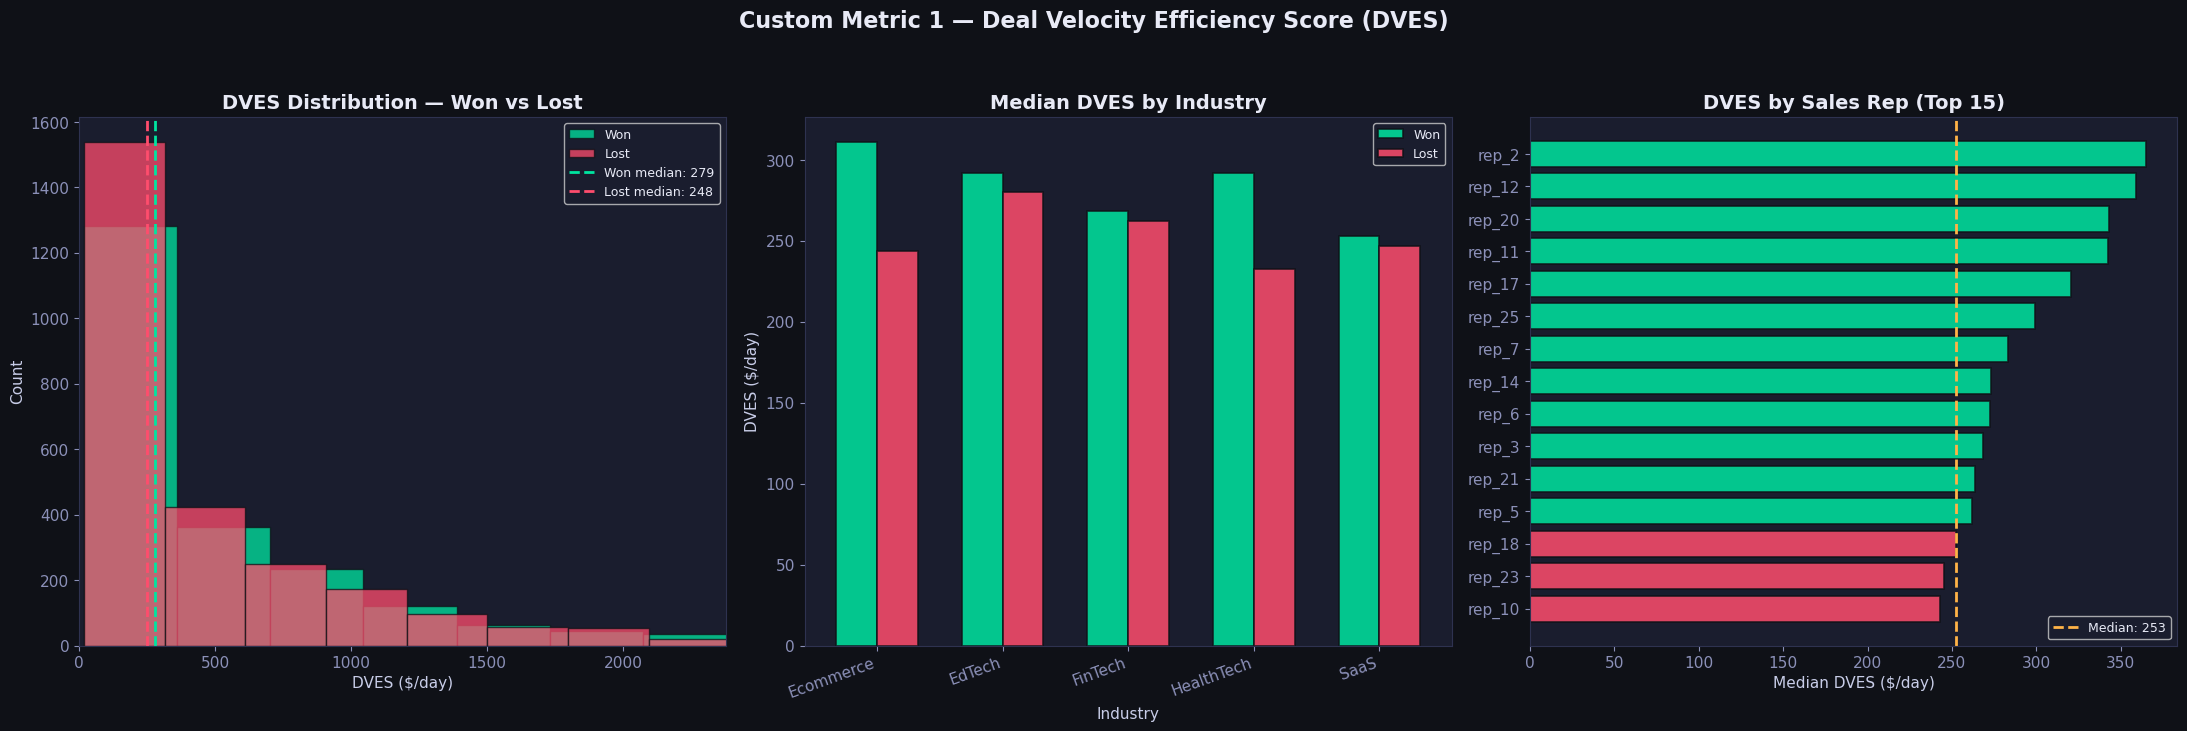

✅ Custom Metric 1 — DVES saved


In [59]:
# ── GRAPH: Custom Metric 1 — DVES ─────────────────────────────────────────────

fig, axes = plt.subplots(1, 3, figsize=(22, 7), facecolor='#0F1117')
fig.suptitle('Custom Metric 1 — Deal Velocity Efficiency Score (DVES)',
             fontsize=16, fontweight='bold', color='#E8EAF6', y=1.04)

# Sub-plot A: DVES distribution Won vs Lost
ax = axes[0]

ax.hist(won_dves,  bins=40, alpha=0.75, color=WON_COLOR,
        label='Won',  edgecolor='#0F1117')
ax.hist(lost_dves, bins=40, alpha=0.75, color=LOST_COLOR,
        label='Lost', edgecolor='#0F1117')

ax.axvline(won_dves.median(), color=WON_COLOR, linestyle='--',
           linewidth=2, label=f"Won median: {won_dves.median():.0f}")
ax.axvline(lost_dves.median(), color=LOST_COLOR, linestyle='--',
           linewidth=2, label=f"Lost median: {lost_dves.median():.0f}")

ax.set_xlim(0, df['dves'].quantile(0.95))
ax.set_title('DVES Distribution — Won vs Lost')
ax.set_xlabel('DVES ($/day)')
ax.set_ylabel('Count')
ax.legend(fontsize=9)

# Sub-plot B: Median DVES per industry
ax2 = axes[1]

calc_dves_ind_plot = calc_dves_ind.set_index('industry')[['Won', 'Lost']]
calc_dves_ind_plot.plot(kind='bar', ax=ax2,
                        color=[WON_COLOR, LOST_COLOR],
                        edgecolor='#0F1117', linewidth=1.2,
                        alpha=0.85, width=0.65)

ax2.set_title('Median DVES by Industry')
ax2.set_xlabel('Industry')
ax2.set_ylabel('DVES ($/day)')
ax2.legend(['Won', 'Lost'], fontsize=9)
plt.setp(ax2.get_xticklabels(), rotation=20, ha='right')

# Sub-plot C: DVES per rep (Top N)
ax3 = axes[2]

rep_top = calc_rep_dves_top.set_index('sales_rep_id')['median_dves']
rep_colors = [WON_COLOR if v > calc_rep_dves_median else LOST_COLOR for v in rep_top]

ax3.barh(rep_top.index[::-1], rep_top.values[::-1],
         color=rep_colors[::-1], alpha=0.85,
         edgecolor='#0F1117', linewidth=1.2)

ax3.axvline(calc_rep_dves_median, color=ACCENT2, linestyle='--',
            linewidth=2, label=f'Median: {calc_rep_dves_median:.0f}')

ax3.set_title(f'DVES by Sales Rep (Top {top_n})')
ax3.set_xlabel('Median DVES ($/day)')
ax3.legend(fontsize=9)

plt.tight_layout()
plt.savefig('outputs/06_custom_metric1_dves.png', dpi=150,
            bbox_inches='tight', facecolor='#0F1117')
plt.show()

print('✅ Custom Metric 1 — DVES saved')


This introduces a custom metric: **DVES (Deal Velocity Efficiency Score) = Deal Amount / Sales Cycle Days**, which measures **revenue generated per day of sales effort**. It captures both value (ACV) and speed (cycle length) in a single efficiency signal.

DVES clearly separates winners from losers:
- **Median DVES:** Won = **278.7** vs Lost = **248.4**  
- **Mean DVES:** Won = **690.0** vs Lost = **631.2**  
Deals that close successfully generate **more revenue per day** than deals that are ultimately lost, indicating that **fast-moving value is a strong quality signal**.

The pattern is consistent across industries:
- In every industry, **median DVES is higher for won deals than for lost deals** (e.g., Ecommerce: **311 vs 244**; HealthTech: **292 vs 232**).  
This shows DVES is a **robust, cross-cutting predictor** rather than an industry-specific artifact.

At the rep level, performance dispersion is large:
- Top reps (e.g., **rep_2: 365**, **rep_12: 359**) significantly outperform the **median rep DVES (~252.7)**.  
This indicates that some reps consistently work **higher-velocity, higher-quality deals**, not just higher volume.

Business takeaway:
- DVES captures a meaningful notion of **deal quality and sales efficiency** that win rate alone misses.
- Low DVES deals are disproportionately likely to be lost and consume sales capacity inefficiently.

Action-wise:
- Use DVES as a **real-time risk and prioritization signal**: low-DVES deals should trigger coaching or deprioritization.
- Set DVES-based thresholds by segment (e.g., Enterprise vs Core) to guide pipeline focus.
- Use rep-level DVES to identify and replicate **best practices** (qualification, stakeholder mapping, deal acceleration) from top performers.


---
##  Custom Metric — Rep Relative Performance Score (RRPS)

In [62]:
# ── CALC 0: Segment Baseline Win Rate (Industry × Region) ──────────────────────
calc_seg_baseline = (
    df.groupby(['industry', 'region'])['won']
      .mean()
      .reset_index()
      .rename(columns={'won': 'seg_win_rate'})
)

calc_seg_baseline['seg_win_rate_pct'] = (calc_seg_baseline['seg_win_rate'] * 100).round(2)

print("=== CALC 0: Segment Baseline (Industry × Region) ===")
print(calc_seg_baseline[['industry', 'region', 'seg_win_rate_pct']].to_string(index=False))


=== CALC 0: Segment Baseline (Industry × Region) ===
  industry        region  seg_win_rate_pct
 Ecommerce          APAC             44.69
 Ecommerce        Europe             45.45
 Ecommerce         India             46.21
 Ecommerce North America             43.33
    EdTech          APAC             41.08
    EdTech        Europe             44.24
    EdTech         India             44.35
    EdTech North America             46.91
   FinTech          APAC             47.26
   FinTech        Europe             46.12
   FinTech         India             47.97
   FinTech North America             49.36
HealthTech          APAC             44.79
HealthTech        Europe             47.20
HealthTech         India             43.42
HealthTech North America             42.73
      SaaS          APAC             46.98
      SaaS        Europe             45.04
      SaaS         India             46.88
      SaaS North America             42.07


In [63]:
# ── CALC 1: Rep Actual Win Rate vs Segment Baseline + RRPS ─────────────────────
df2 = df.merge(calc_seg_baseline[['industry','region','seg_win_rate']], 
               on=['industry','region'], how='left')

calc_rep_rrps = (
    df2.groupby('sales_rep_id')
       .agg(
           actual_wr=('won', 'mean'),
           seg_baseline=('seg_win_rate', 'mean'),
           total_deals=('won', 'count')
       )
       .reset_index()
)

calc_rep_rrps['actual_wr_pct']   = (calc_rep_rrps['actual_wr'] * 100).round(2)
calc_rep_rrps['seg_baseline_pct']= (calc_rep_rrps['seg_baseline'] * 100).round(2)
calc_rep_rrps['rrps']            = ((calc_rep_rrps['actual_wr'] - calc_rep_rrps['seg_baseline']) * 100).round(2)

calc_rep_rrps = calc_rep_rrps.sort_values('rrps', ascending=False)

print("=== CALC 1: Rep Actual WR vs Segment Baseline + RRPS ===")
print(calc_rep_rrps[['sales_rep_id', 'actual_wr_pct', 'seg_baseline_pct', 'rrps', 'total_deals']].to_string(index=False))


=== CALC 1: Rep Actual WR vs Segment Baseline + RRPS ===
sales_rep_id  actual_wr_pct  seg_baseline_pct  rrps  total_deals
      rep_21          50.96             45.35  5.62          208
      rep_12          48.33             45.27  3.06          180
      rep_19          47.96             44.97  2.99          196
       rep_8          48.13             45.17  2.96          187
       rep_3          47.22             44.86  2.37          216
      rep_16          47.09             45.31  1.78          223
      rep_20          46.96             45.39  1.57          230
      rep_11          46.50             45.43  1.07          200
       rep_2          46.15             45.39  0.77          221
       rep_4          45.81             45.17  0.65          203
       rep_5          45.77             45.40  0.37          201
       rep_1          45.50             45.46  0.04          211
      rep_25          45.37             45.40 -0.04          205
      rep_24          44.83      

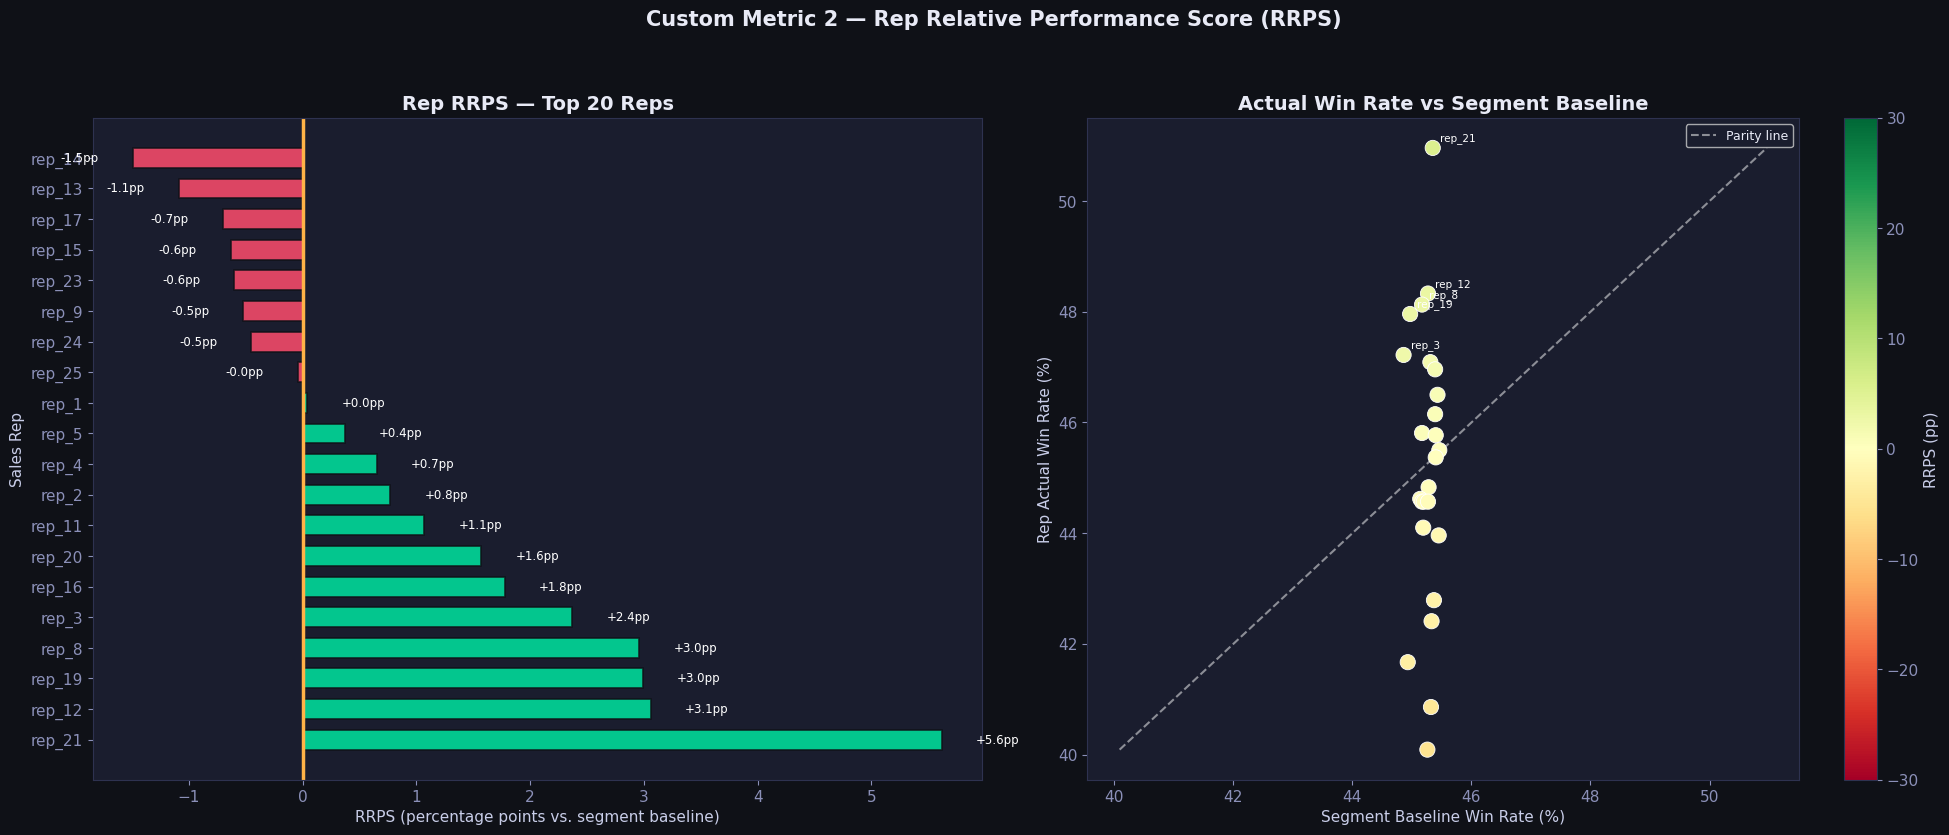

✅ Custom Metric 2 — RRPS saved


In [64]:
# ── GRAPH: Custom Metric 2 — Rep Relative Performance Score (RRPS) ─────────────

fig, axes = plt.subplots(1, 2, figsize=(20, 8), facecolor='#0F1117')
fig.suptitle('Custom Metric 2 — Rep Relative Performance Score (RRPS)',
             fontsize=15, fontweight='bold', color='#E8EAF6', y=1.04)

# Sub-plot A: RRPS waterfall (Top 20)
ax = axes[0]

top_n = 20
top_reps = calc_rep_rrps.head(top_n)

bar_colors = [WON_COLOR if v > 0 else LOST_COLOR for v in top_reps['rrps']]

bars = ax.barh(top_reps['sales_rep_id'], top_reps['rrps'],
               color=bar_colors, alpha=0.85, edgecolor='#0F1117',
               linewidth=1.2, height=0.65)

ax.axvline(0, color=ACCENT2, linewidth=2.5)

for bar, val in zip(bars, top_reps['rrps']):
    xpos = val + 0.3 if val >= 0 else val - 0.3
    ha = 'left' if val >= 0 else 'right'
    ax.text(xpos, bar.get_y() + bar.get_height()/2,
            f'{val:+.1f}pp', va='center', ha=ha,
            color='white', fontsize=8.5)

ax.set_title('Rep RRPS — Top 20 Reps')
ax.set_xlabel('RRPS (percentage points vs. segment baseline)')
ax.set_ylabel('Sales Rep')

# Sub-plot B: Actual WR vs Segment Baseline scatter
ax2 = axes[1]

sc = ax2.scatter(calc_rep_rrps['seg_baseline_pct'], calc_rep_rrps['actual_wr_pct'],
                 c=calc_rep_rrps['rrps'], cmap='RdYlGn', s=120,
                 edgecolors='white', linewidth=0.6, zorder=3, vmin=-30, vmax=30)

mn = min(calc_rep_rrps['seg_baseline_pct'].min(), calc_rep_rrps['actual_wr_pct'].min())
mx = max(calc_rep_rrps['seg_baseline_pct'].max(), calc_rep_rrps['actual_wr_pct'].max())

ax2.plot([mn, mx], [mn, mx], 'w--', linewidth=1.5, alpha=0.5, label='Parity line')

for _, row in calc_rep_rrps.head(5).iterrows():
    ax2.annotate(row['sales_rep_id'],
                 xy=(row['seg_baseline_pct'], row['actual_wr_pct']),
                 xytext=(5, 5), textcoords='offset points',
                 color='white', fontsize=7.5)

plt.colorbar(sc, ax=ax2, label='RRPS (pp)')

ax2.set_title('Actual Win Rate vs Segment Baseline')
ax2.set_xlabel('Segment Baseline Win Rate (%)')
ax2.set_ylabel('Rep Actual Win Rate (%)')
ax2.legend(fontsize=9)

plt.tight_layout()
plt.savefig('outputs/07_custom_metric2_rrps.png', dpi=150,
            bbox_inches='tight', facecolor='#0F1117')
plt.show()

print('✅ Custom Metric 2 — RRPS saved')


This introduces a second custom metric: **RRPS (Rep Relative Performance Score)**, defined as:

> **RRPS = Rep Actual Win Rate − Segment Baseline Win Rate (Industry × Region)**

This controls for territory difficulty and deal mix, so reps are compared **fairly** against the expected win rate of the segments they sell into.

The spread in RRPS is meaningful:
- Top performers materially outperform their segment baseline (e.g., **rep_21: +5.62pp**, **rep_12: +3.06pp**, **rep_19: +2.99pp**).
- Bottom performers significantly underperform expected conversion (e.g., **rep_22: −5.16pp**, **rep_18: −4.46pp**, **rep_7: −3.26pp**).
- These gaps persist across **large sample sizes (~175–230 deals per rep)**, so the differences are unlikely to be noise.

This shows that not all win-rate variance is due to market or territory difficulty. There is **true execution variance at the rep level** that standard win rate masks.

Business takeaway:
- RRPS isolates **coaching and performance gaps** more accurately than raw win rate.
- It helps distinguish reps who are strong performers in hard segments from those who look average only because they sell into easier segments.

Action-wise:
- Use RRPS to **prioritize coaching** and targeted enablement for underperforming reps.
- Identify behaviors from high-RRPS reps (deal qualification, stakeholder mapping, objection handling) and codify them into playbooks.
- Incorporate RRPS into performance reviews and territory planning to ensure incentives reflect **difficulty-adjusted performance**, not just raw outcomes.


> **Business Meaning:** RRPS separates rep skill from territory difficulty. A rep with 40% win rate in a 35% baseline market is actually a star. RRPS surfaces *true* underperformers vs reps who just drew harder territories — without this, managers would wrongly coach high performers and ignore the real problems.

---
##  Deal Size Analysis — Where is Revenue Leaking?

In [68]:
# ── CALC A: Win Rate, Count, Lost Revenue by Deal Size Bucket ──────────────────
calc_size_wr = (
    df.groupby('deal_size_bucket')
      .agg(
          win_rate_pct=('won', lambda x: round(x.mean() * 100, 2)),
          total_deals=('won', 'count'),
          lost_revenue=('deal_amount', lambda x: x[df.loc[x.index, 'won'] == 0].sum())
      )
      .reset_index()
)

calc_size_wr['lost_revenue_m'] = (calc_size_wr['lost_revenue'] / 1e6).round(3)

print("=== CALC A: Win Rate, Count, Lost Revenue by Deal Size Bucket ===")
print(calc_size_wr[['deal_size_bucket', 'win_rate_pct', 'total_deals', 'lost_revenue_m']].to_string(index=False))


=== CALC A: Win Rate, Count, Lost Revenue by Deal Size Bucket ===
deal_size_bucket  win_rate_pct  total_deals  lost_revenue_m
             <5K         45.12          820           1.574
          5K–15K         44.17         1809           9.348
         15K–30K         46.03          945           9.713
         30K–60K         44.95          594          14.731
            60K+         47.12          832          35.477


In [69]:
# ── CALC B: Revenue Won vs Lost by Deal Size Bucket ────────────────────────────
calc_rev_won = (
    df[df['won'] == 1]
    .groupby('deal_size_bucket')['deal_amount']
    .sum()
    .reset_index(name='won_revenue')
)

calc_rev_lost = (
    df[df['won'] == 0]
    .groupby('deal_size_bucket')['deal_amount']
    .sum()
    .reset_index(name='lost_revenue')
)

calc_rev_size = calc_rev_won.merge(calc_rev_lost, on='deal_size_bucket', how='outer')

calc_rev_size['won_revenue']  = calc_rev_size['won_revenue'].fillna(0)
calc_rev_size['lost_revenue'] = calc_rev_size['lost_revenue'].fillna(0)

calc_rev_size['won_revenue_m']  = (calc_rev_size['won_revenue']  / 1e6).round(3)
calc_rev_size['lost_revenue_m'] = (calc_rev_size['lost_revenue'] / 1e6).round(3)

print("=== CALC B: Revenue Won vs Lost by Deal Size Bucket ($M) ===")
print(calc_rev_size[['deal_size_bucket', 'won_revenue_m', 'lost_revenue_m']].to_string(index=False))


=== CALC B: Revenue Won vs Lost by Deal Size Bucket ($M) ===
deal_size_bucket  won_revenue_m  lost_revenue_m
             <5K          1.290           1.574
          5K–15K          7.395           9.348
         15K–30K          8.395           9.713
         30K–60K         12.131          14.731
            60K+         31.379          35.477


In [70]:
# ── CALC C: Deal Amount Distribution (Won vs Lost) ─────────────────────────────
calc_amount_dist = pd.DataFrame({
    'metric': [
        'won_median_k', 'lost_median_k',
        'won_mean_k', 'lost_mean_k',
        'won_count', 'lost_count'
    ],
    'value': [
        round((df[df['won'] == 1]['deal_amount'] / 1000).median(), 2),
        round((df[df['won'] == 0]['deal_amount'] / 1000).median(), 2),
        round((df[df['won'] == 1]['deal_amount'] / 1000).mean(), 2),
        round((df[df['won'] == 0]['deal_amount'] / 1000).mean(), 2),
        df[df['won'] == 1].shape[0],
        df[df['won'] == 0].shape[0]
    ]
})

print("=== CALC C: Deal Amount Distribution (Won vs Lost) ===")
print(calc_amount_dist.to_string(index=False))


=== CALC C: Deal Amount Distribution (Won vs Lost) ===
       metric   value
 won_median_k   14.62
lost_median_k   13.80
   won_mean_k   26.77
  lost_mean_k   25.88
    won_count 2263.00
   lost_count 2737.00


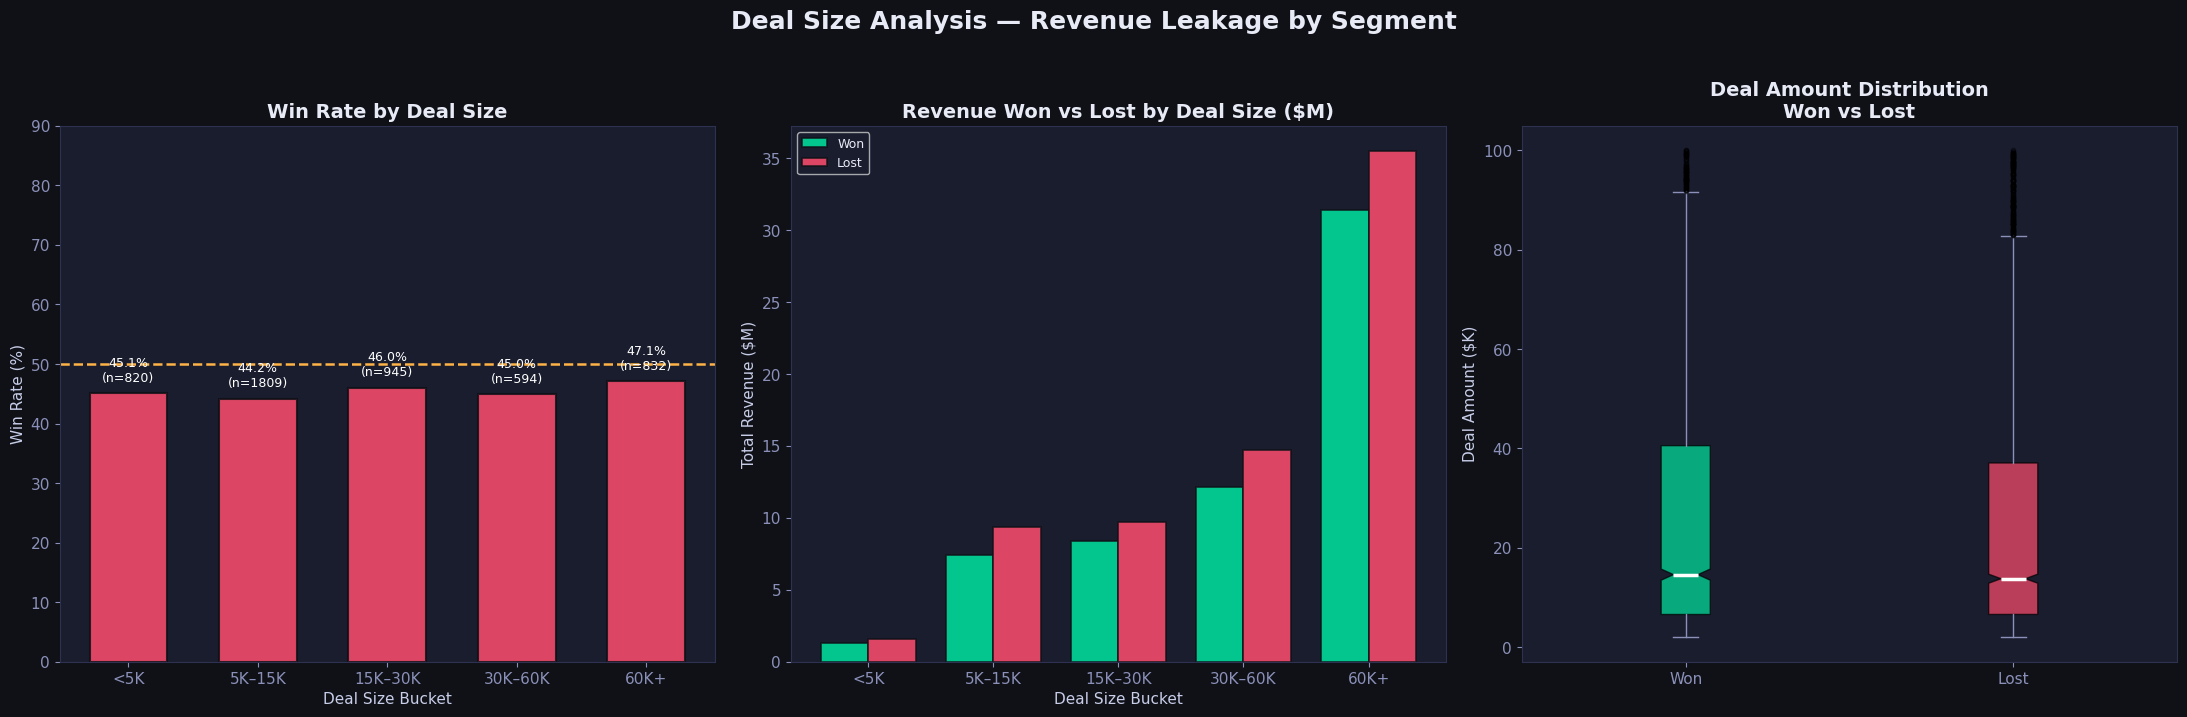

In [71]:
# ── GRAPH: Deal Size Analysis — Revenue Leakage by Segment ─────────────────────

fig, axes = plt.subplots(1, 3, figsize=(22, 7), facecolor='#0F1117')
fig.suptitle('Deal Size Analysis — Revenue Leakage by Segment',
             fontsize=18, fontweight='bold', color='#E8EAF6', y=1.02)

# Sub-plot A: Win rate by deal size bucket
ax = axes[0]

bars = ax.bar(calc_size_wr['deal_size_bucket'].astype(str), calc_size_wr['win_rate_pct'],
              color=[WON_COLOR if v >= 50 else LOST_COLOR for v in calc_size_wr['win_rate_pct']],
              alpha=0.85, edgecolor='#0F1117',
              linewidth=1.5, width=0.6)

ax.axhline(50, color=ACCENT2, linestyle='--', linewidth=1.8)

for bar, row in zip(bars, calc_size_wr.itertuples()):
    ax.text(bar.get_x() + bar.get_width()/2, row.win_rate_pct + 1.5,
            f'{row.win_rate_pct:.1f}%\n(n={row.total_deals})',
            ha='center', va='bottom', color='white', fontsize=9)

ax.set_title('Win Rate by Deal Size')
ax.set_xlabel('Deal Size Bucket')
ax.set_ylabel('Win Rate (%)')
ax.set_ylim(0, 90)

# Sub-plot B: Revenue won vs lost by deal size bucket
ax2 = axes[1]

x = np.arange(len(calc_rev_size['deal_size_bucket']))
w = 0.38

ax2.bar(x - w/2, calc_rev_size['won_revenue_m'],  width=w, color=WON_COLOR,
        alpha=0.85, edgecolor='#0F1117', linewidth=1.2, label='Won')

ax2.bar(x + w/2, calc_rev_size['lost_revenue_m'], width=w, color=LOST_COLOR,
        alpha=0.85, edgecolor='#0F1117', linewidth=1.2, label='Lost')

ax2.set_xticks(x)
ax2.set_xticklabels(calc_rev_size['deal_size_bucket'].astype(str))
ax2.set_title('Revenue Won vs Lost by Deal Size ($M)')
ax2.set_xlabel('Deal Size Bucket')
ax2.set_ylabel('Total Revenue ($M)')
ax2.legend(fontsize=9)

# Sub-plot C: Deal amount box plot Won vs Lost
ax3 = axes[2]

won_amounts  = df[df['won'] == 1]['deal_amount'] / 1000
lost_amounts = df[df['won'] == 0]['deal_amount'] / 1000

bp = ax3.boxplot([won_amounts, lost_amounts],
                 labels=['Won','Lost'],
                 patch_artist=True, notch=True,
                 medianprops=dict(color='white', linewidth=2.5),
                 whiskerprops=dict(color='#8B90B8'),
                 capprops=dict(color='#8B90B8'),
                 flierprops=dict(marker='o', color='#8B90B8', alpha=0.4, markersize=3))

bp['boxes'][0].set_facecolor(WON_COLOR);  bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor(LOST_COLOR); bp['boxes'][1].set_alpha(0.7)

ax3.set_title('Deal Amount Distribution\nWon vs Lost')
ax3.set_ylabel('Deal Amount ($K)')

plt.tight_layout()
plt.savefig('outputs/08_deal_size_analysis.png', dpi=150,
            bbox_inches='tight', facecolor='#0F1117')
plt.show()


Win rate is relatively flat across deal sizes (≈44–47%), but **revenue leakage increases sharply with deal size**. The largest bucket (**60K+**) leaks **~$35.5M** in lost revenue versus **~$31.4M** won, creating the single biggest revenue gap despite having the **highest win rate (47.12%)** among buckets.

Mid-to-large deals are the main revenue risk:
- **30K–60K:** ~$14.7M lost vs ~$12.1M won  
- **15K–30K:** ~$9.7M lost vs ~$8.4M won  
This shows that even small percentage-point improvements in conversion at higher ACV would yield **outsized revenue impact**.

Deal amount distributions for won vs lost are similar (median: **$14.6K won vs $13.8K lost**; mean: **$26.8K vs $25.9K**), indicating that **deal size alone does not explain losses**. The issue is not “big deals are bad,” but that **large, complex deals are harder to convert and cost more when lost**.

Business takeaway:
- The win-rate problem is disproportionately a **large-deal revenue problem**, not a small-deal volume problem.
- Optimizing conversion on high-ACV deals is the highest-leverage path to revenue uplift.

Action-wise:
- Prioritize **deal coaching and exec sponsorship** for **30K+ opportunities**.
- Apply stricter **qualification and risk scoring** to large deals earlier in the funnel.
- Track a revenue-weighted metric (e.g., **Lost Revenue Concentration by ACV bucket**) so leadership doesn’t optimize win rate % while still leaking the majority of revenue.


---
##  Rep Performance Deep-Dive

In [74]:
# ── CALC: Sales Rep Performance Stats ─────────────────────────────────────────
calc_rep_stats = (
    df.groupby('sales_rep_id')
      .agg(
          total_deals   =('won','count'),
          won_deals     =('won','sum'),
          win_rate_pct  =('won', lambda x: round(x.mean() * 100, 2)),
          avg_deal_k    =('deal_amount', lambda x: round(x.mean() / 1000, 2)),
          avg_cycle     =('sales_cycle_days','mean'),
          total_rev_won_m=('deal_amount', lambda x: round(x[df.loc[x.index,'won'] == 1].sum() / 1e6, 3)),
          median_dves   =('dves','median')
      )
      .reset_index()
)

print("=== CALC: Sales Rep Performance Stats (All Reps) ===")
print(calc_rep_stats.to_string(index=False))


=== CALC: Sales Rep Performance Stats (All Reps) ===
sales_rep_id  total_deals  won_deals  win_rate_pct  avg_deal_k  avg_cycle  total_rev_won_m  median_dves
       rep_1          211         96         45.50       25.24  66.691943            2.483   228.037975
      rep_10          191         81         42.41       25.63  63.853403            1.946   242.775862
      rep_11          200         93         46.50       30.27  66.710000            2.902   342.847368
      rep_12          180         87         48.33       30.79  59.672222            2.386   359.279977
      rep_13          195         86         44.10       24.79  68.456410            2.553   215.878788
      rep_14          207         91         43.96       25.35  63.695652            2.554   273.312500
      rep_15          175         78         44.57       23.92  66.817143            1.739   241.561404
      rep_16          223        105         47.09       25.55  64.367713            2.846   235.068966
      rep_1

In [75]:
# ── CALC: Active Reps (>= 10 deals) ────────────────────────────────────────────
calc_rep_active = calc_rep_stats[calc_rep_stats['total_deals'] >= 10].sort_values('win_rate_pct', ascending=False)

print("=== CALC: Active Reps (>= 10 deals) ===")
print(calc_rep_active[['sales_rep_id','total_deals','won_deals','win_rate_pct','avg_deal_k','avg_cycle','total_rev_won_m','median_dves']].to_string(index=False))


=== CALC: Active Reps (>= 10 deals) ===
sales_rep_id  total_deals  won_deals  win_rate_pct  avg_deal_k  avg_cycle  total_rev_won_m  median_dves
      rep_21          208        106         50.96       23.27  65.336538            2.700   263.490196
      rep_12          180         87         48.33       30.79  59.672222            2.386   359.279977
       rep_8          187         90         48.13       26.47  65.171123            2.396   220.111111
      rep_19          196         94         47.96       27.31  65.132653            2.680   241.940722
       rep_3          216        102         47.22       24.24  62.949074            2.597   268.293156
      rep_16          223        105         47.09       25.55  64.367713            2.846   235.068966
      rep_20          230        108         46.96       27.18  62.034783            3.123   342.867368
      rep_11          200         93         46.50       30.27  66.710000            2.902   342.847368
       rep_2          22

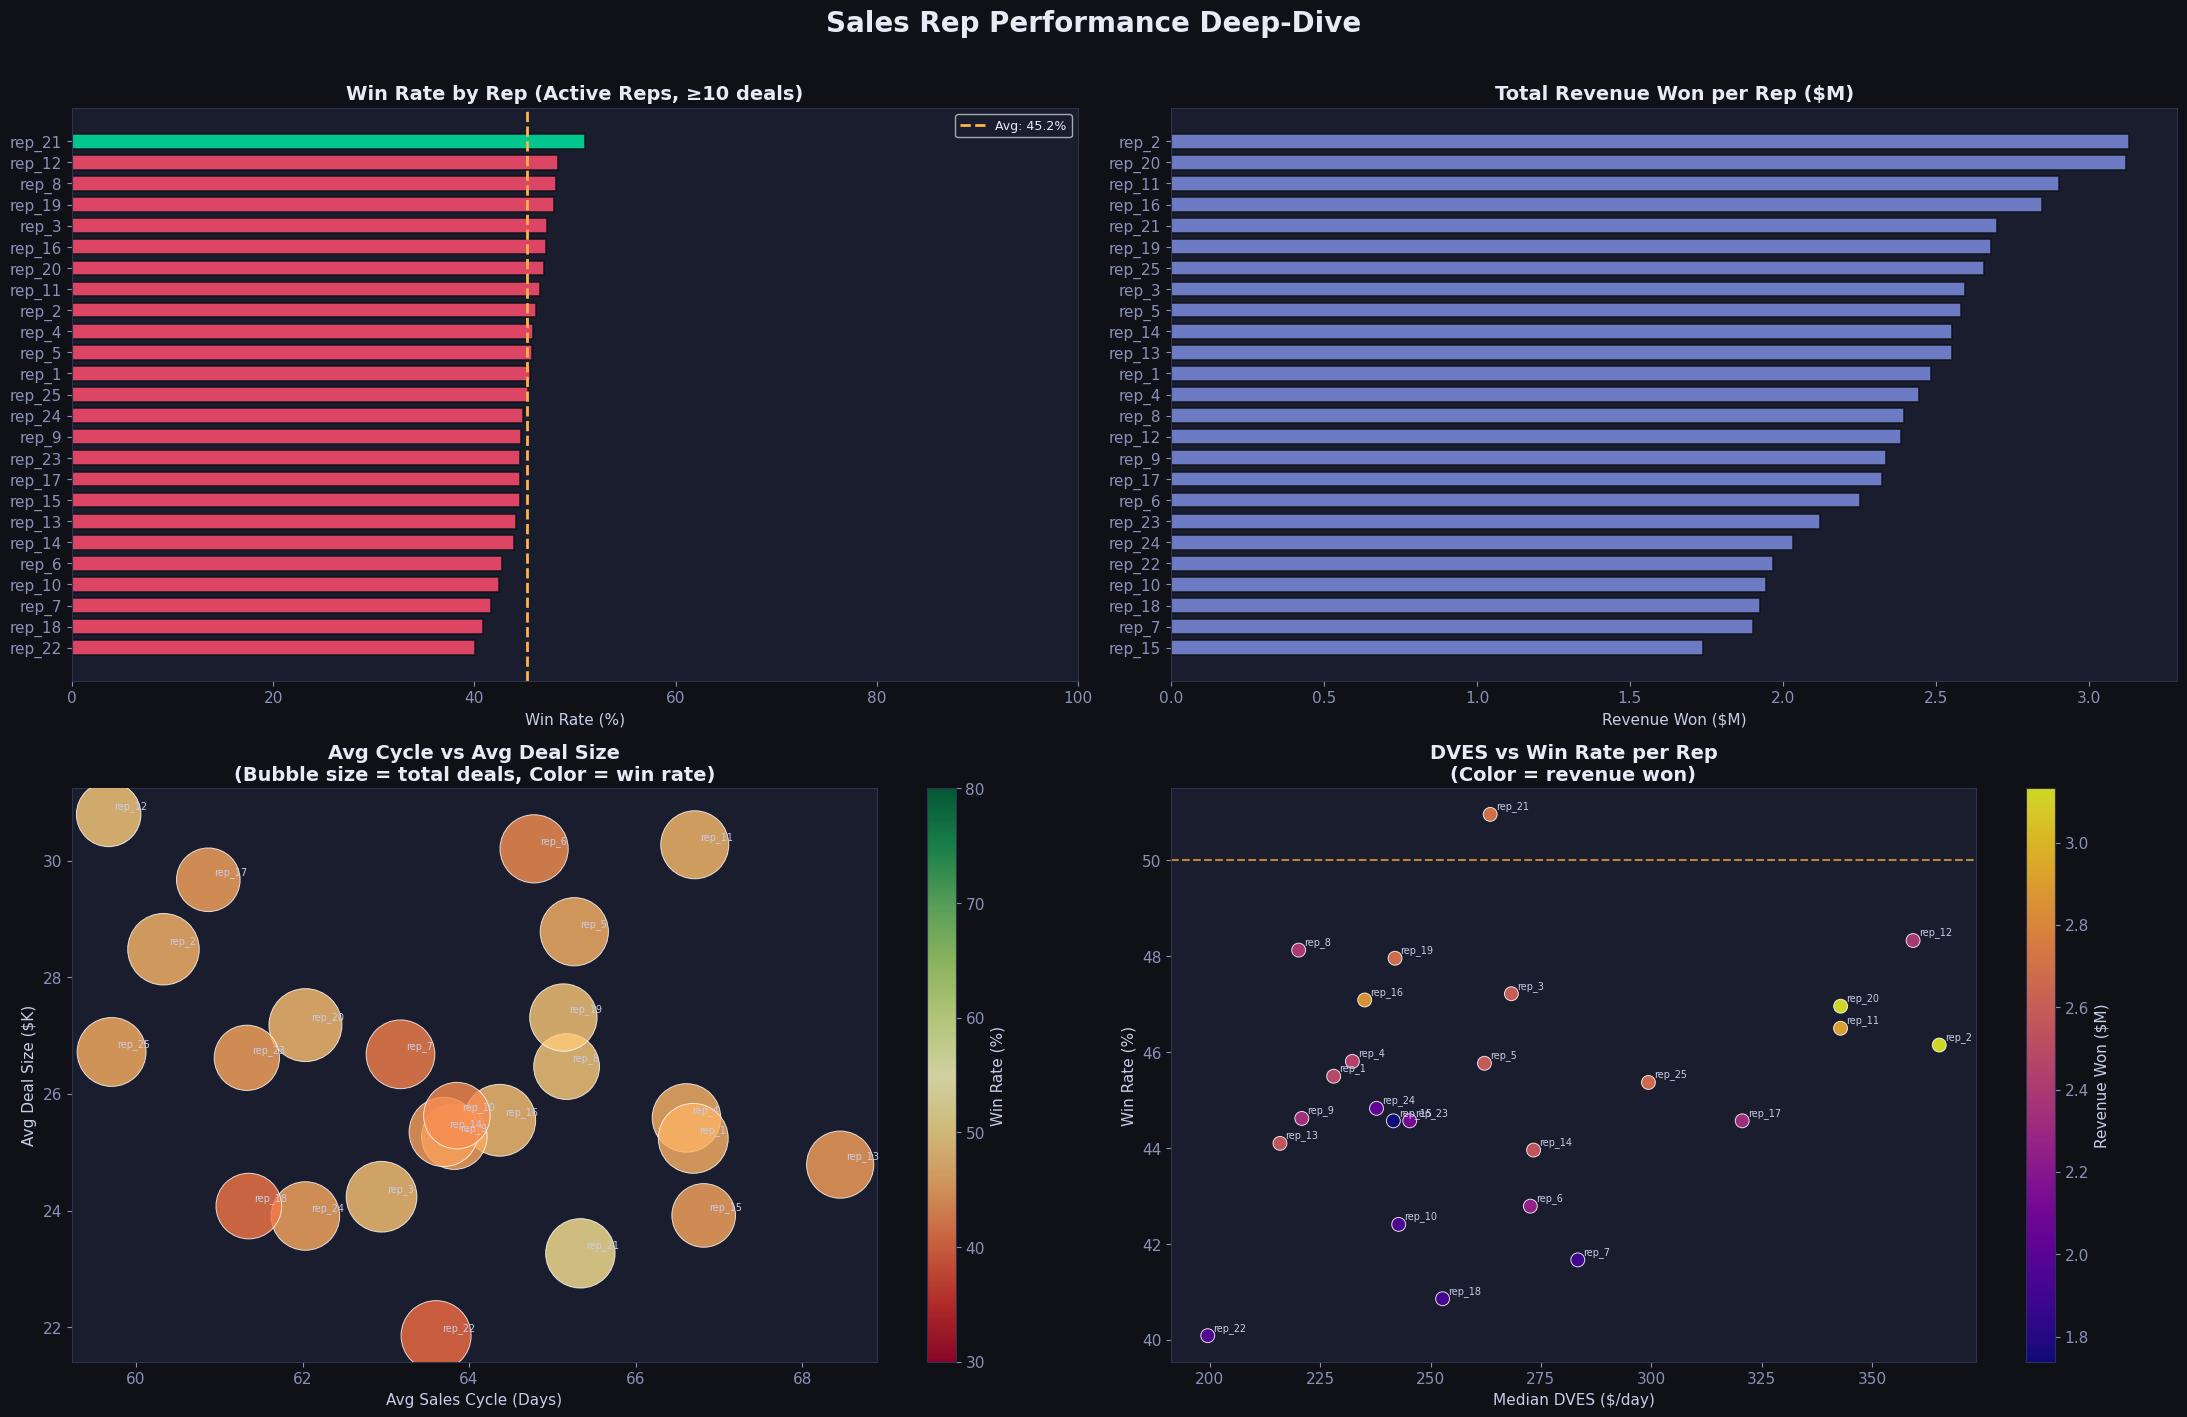

In [76]:
# ── GRAPH: Sales Rep Performance Deep-Dive ────────────────────────────────────

fig, axes = plt.subplots(2, 2, figsize=(22, 14), facecolor='#0F1117')
fig.suptitle('Sales Rep Performance Deep-Dive',
             fontsize=20, fontweight='bold', color='#E8EAF6', y=1.01)

# Panel A: Win rate per rep (sorted)
ax = axes[0,0]
r_sorted = calc_rep_active.sort_values('win_rate_pct', ascending=True)

bar_cols = [WON_COLOR if v >= 50 else LOST_COLOR for v in r_sorted['win_rate_pct']]

ax.barh(r_sorted['sales_rep_id'], r_sorted['win_rate_pct'],
        color=bar_cols, alpha=0.85, edgecolor='#0F1117', linewidth=1.2, height=0.7)

ax.axvline(calc_rep_active['win_rate_pct'].mean(), color=ACCENT2, linestyle='--',
           linewidth=2, label=f"Avg: {calc_rep_active['win_rate_pct'].mean():.1f}%")

ax.set_title('Win Rate by Rep (Active Reps, ≥10 deals)')
ax.set_xlabel('Win Rate (%)')
ax.legend(fontsize=9)
ax.set_xlim(0, 100)

# Panel B: Total revenue won per rep
ax2 = axes[0,1]
r_rev = calc_rep_active.sort_values('total_rev_won_m', ascending=True)

ax2.barh(r_rev['sales_rep_id'], r_rev['total_rev_won_m'],
         color=ACCENT, alpha=0.85, edgecolor='#0F1117', linewidth=1.2, height=0.7)

ax2.set_title('Total Revenue Won per Rep ($M)')
ax2.set_xlabel('Revenue Won ($M)')

# Panel C: Avg deal size vs avg cycle (bubble = total deals)
ax3 = axes[1,0]

sc = ax3.scatter(
    calc_rep_active['avg_cycle'], calc_rep_active['avg_deal_k'],
    s=calc_rep_active['total_deals'] * 12,
    c=calc_rep_active['win_rate_pct'], cmap='RdYlGn',
    alpha=0.8, edgecolors='white', linewidth=0.7,
    vmin=30, vmax=80, zorder=3
)

for _, row in calc_rep_active.iterrows():
    ax3.annotate(row['sales_rep_id'],
                 xy=(row['avg_cycle'], row['avg_deal_k']),
                 xytext=(4, 4), textcoords='offset points',
                 color='#C8CDE8', fontsize=7)

plt.colorbar(sc, ax=ax3, label='Win Rate (%)')

ax3.set_title('Avg Cycle vs Avg Deal Size\n(Bubble size = total deals, Color = win rate)')
ax3.set_xlabel('Avg Sales Cycle (Days)')
ax3.set_ylabel('Avg Deal Size ($K)')

# Panel D: Rep DVES vs Win Rate correlation
ax4 = axes[1,1]

sc2 = ax4.scatter(
    calc_rep_active['median_dves'], calc_rep_active['win_rate_pct'],
    c=calc_rep_active['total_rev_won_m'], cmap='plasma',
    s=100, edgecolors='white', linewidth=0.7, alpha=0.85, zorder=3
)

for _, row in calc_rep_active.iterrows():
    ax4.annotate(row['sales_rep_id'],
                 xy=(row['median_dves'], row['win_rate_pct']),
                 xytext=(4, 4), textcoords='offset points',
                 color='#C8CDE8', fontsize=7)

plt.colorbar(sc2, ax=ax4, label='Revenue Won ($M)')

ax4.axhline(50, color=ACCENT2, linestyle='--', linewidth=1.5, alpha=0.7)

ax4.set_title('DVES vs Win Rate per Rep\n(Color = revenue won)')
ax4.set_xlabel('Median DVES ($/day)')
ax4.set_ylabel('Win Rate (%)')

plt.tight_layout()
plt.savefig('outputs/09_rep_performance.png', dpi=150,
            bbox_inches='tight', facecolor='#0F1117')
plt.show()


Sales performance varies materially by rep, even though most reps operate in similar win-rate bands (~41%–51%). This indicates that **rep execution quality is a real driver** of outcomes, not just market or segment mix.

Top vs bottom performance is meaningful:
- **rep_21** leads with **50.96% win rate** on **208 deals**, showing this is not a small-sample artifact.
- Bottom performers (e.g., **rep_22: 40.09%**, **rep_18: 40.86%**) trail the average by ~5–6 pp, which is large at this scale.
- Total revenue won varies widely (e.g., **rep_2 ~ $3.13M**, **rep_20 ~ $3.12M** vs several reps below $2.0M), indicating that impact is driven by both conversion and deal mix.

Win rate alone does not explain revenue impact:
- Some reps with similar win rates generate more revenue due to **larger average deal sizes** (e.g., reps with ~$30K avg deals).
- **DVES correlates with win rate** at the rep level: higher DVES reps cluster above the average win rate, suggesting that working higher-velocity deals is associated with better outcomes.

Business takeaway:
- There is **rep-level execution variance** that materially affects revenue outcomes.
- Improving the bottom quartile of reps to the median would likely unlock more revenue than marginally improving already-strong reps.

Action-wise:
- Prioritize **targeted coaching** for low-performing reps using DVES + RRPS to pinpoint whether issues are qualification quality, deal velocity, or late-stage execution.
- Identify behaviors from high performers (e.g., faster deal progression with similar ACV) and codify them into playbooks.
- Use rep-level diagnostics to allocate **deal support resources** (SE time, exec sponsorship) to reps handling high-ACV or low-DVES opportunities.


---
## Pipeline Health — Stage × Outcome Analysis

In [79]:
# ── CALC A: Win Rate by Deal Stage ─────────────────────────────────────────────
stage_order = ['Demo','Qualified','Proposal','Negotiation','Closed']

calc_stage_stats = (
    df.groupby('deal_stage')['won']
      .agg(total_deals='count', win_rate_pct=lambda x: round(x.mean() * 100, 2))
      .reindex(stage_order)
      .dropna()
      .reset_index()
)

print("=== CALC A: Win Rate by Deal Stage ===")
print(calc_stage_stats.to_string(index=False))


=== CALC A: Win Rate by Deal Stage ===
 deal_stage  total_deals  win_rate_pct
       Demo         1043         45.83
  Qualified          956         42.26
   Proposal         1009         44.70
Negotiation          995         46.63
     Closed          997         46.74


In [80]:
# ── CALC B: Product × Lead Source Win Rate Matrix (%) ──────────────────────────
calc_prod_lead_wr = (
    df.pivot_table(
        index='product_type',
        columns='lead_source',
        values='won',
        aggfunc='mean'
    ) * 100
)

print("=== CALC B: Product × Lead Source Win Rate Matrix (%) ===")
print(calc_prod_lead_wr.round(2).to_string())


=== CALC B: Product × Lead Source Win Rate Matrix (%) ===
lead_source   Inbound  Outbound  Partner  Referral
product_type                                      
Core            49.18     43.84    42.30     46.68
Enterprise      47.67     47.72    39.52     45.17
Pro             41.40     45.17    50.00     44.71


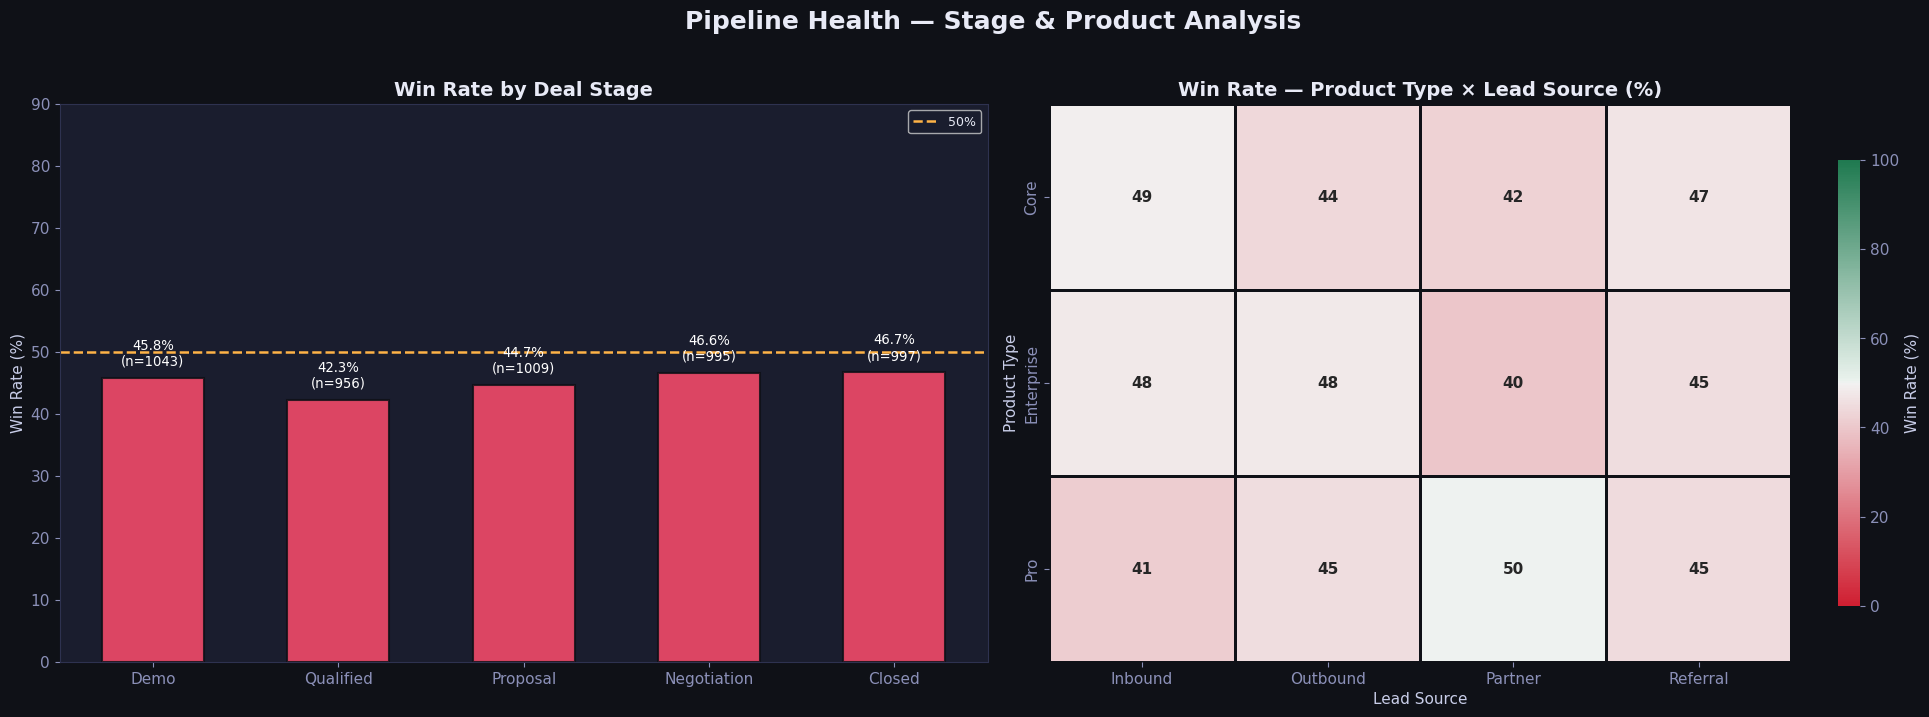

In [81]:
# ── GRAPH: Pipeline Health — Stage & Product Analysis ─────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(20, 7), facecolor='#0F1117')
fig.suptitle('Pipeline Health — Stage & Product Analysis',
             fontsize=18, fontweight='bold', color='#E8EAF6', y=1.02)

# Sub-plot A: Win rate by stage
ax = axes[0]

bars = ax.bar(calc_stage_stats['deal_stage'], calc_stage_stats['win_rate_pct'],
              color=[WON_COLOR if v >= 50 else LOST_COLOR for v in calc_stage_stats['win_rate_pct']],
              alpha=0.85, edgecolor='#0F1117', linewidth=1.5, width=0.55)

ax.axhline(50, color=ACCENT2, linestyle='--', linewidth=1.8, label='50%')

for bar, row in zip(bars, calc_stage_stats.itertuples()):
    ax.text(bar.get_x() + bar.get_width()/2, row.win_rate_pct + 1.5,
            f"{row.win_rate_pct:.1f}%\n(n={int(row.total_deals)})",
            ha='center', va='bottom', color='white', fontsize=9.5)

ax.set_title('Win Rate by Deal Stage')
ax.set_ylabel('Win Rate (%)')
ax.set_ylim(0, 90)
ax.legend(fontsize=9)

# Sub-plot B: Heatmap — product × lead source win rate
ax2 = axes[1]

sns.heatmap(calc_prod_lead_wr, ax=ax2,
            cmap=sns.diverging_palette(10, 145, s=90, l=45, as_cmap=True),
            center=50, vmin=0, vmax=100,
            annot=True, fmt='.0f', annot_kws={'size': 11, 'weight': 'bold'},
            linewidths=2, linecolor='#0F1117',
            cbar_kws={'shrink': 0.8, 'label': 'Win Rate (%)'})

ax2.set_title('Win Rate — Product Type × Lead Source (%)')
ax2.set_xlabel('Lead Source')
ax2.set_ylabel('Product Type')

plt.tight_layout()
plt.savefig('outputs/10_pipeline_stage_product.png', dpi=150,
            bbox_inches='tight', facecolor='#0F1117')
plt.show()


Win rate varies meaningfully by **deal stage**, with the weakest conversion at the **Qualified stage (42.26%)** and steady improvement toward later stages (**Negotiation 46.63%, Closed 46.74%**). This indicates that **early-stage qualification is the biggest leakage point** in the funnel.

The stage pattern suggests two issues:
- Deals entering **Qualified** are not consistently meeting ICP/intent thresholds.
- Losses that happen later in the funnel are harder to prevent, but fewer than the losses created by weak early-stage filtering.

The product × lead-source matrix reveals **specific high-risk combinations**:
- **Enterprise × Partner = 39.52%** is the weakest pairing, indicating poor fit or insufficient partner enablement for complex, high-ACV deals.
- **Core × Outbound = 43.84%** underperforms relative to Inbound (49.18%), suggesting outbound is bringing lower-intent Core buyers.
- **Pro × Inbound = 41.40%** is weaker than expected, indicating potential mismatch between inbound messaging and Pro buyer needs.
- The best-performing pocket is **Pro × Partner (50.00%)**, suggesting partner-led motions can work well when the product complexity is moderate.

Business takeaway:
- The largest win-rate gains are available by **fixing early-stage qualification** and **avoiding known weak product–channel combinations**.
- Broad, one-size-fits-all pipeline optimization will underperform targeted interventions on these specific leak points.

Action-wise:
- Tighten **Qualified-stage entry criteria** (ICP fit, budget owner confirmed, problem urgency).
- Adjust channel strategy by product (e.g., restrict **Enterprise × Partner** until partner enablement improves; shift more **Core** motion to Inbound).
- Encode these patterns into routing and scoring rules so high-risk combinations trigger additional validation or senior review.


---
## Segment Combination Heatmap — Where is the Problem Hiding?

In [84]:
# ── CALC: Industry × Region Win Rate + Deal Count ──────────────────────────────
calc_seg_pivot = df.pivot_table(
    index='industry',
    columns='region',
    values='won',
    aggfunc=['mean', 'count']
)

calc_seg_wr  = calc_seg_pivot['mean'] * 100
calc_seg_cnt = calc_seg_pivot['count']

print("=== CALC: Industry × Region Win Rate (%) ===")
print(calc_seg_wr.round(2).to_string())

print("\n=== CALC: Industry × Region Deal Count (n) ===")
print(calc_seg_cnt.to_string())


=== CALC: Industry × Region Win Rate (%) ===
region       APAC  Europe  India  North America
industry                                       
Ecommerce   44.69   45.45  46.21          43.33
EdTech      41.08   44.24  44.35          46.91
FinTech     47.26   46.12  47.97          49.36
HealthTech  44.79   47.20  43.42          42.73
SaaS        46.98   45.04  46.88          42.07

=== CALC: Industry × Region Deal Count (n) ===
region      APAC  Europe  India  North America
industry                                      
Ecommerce    273     253    264            270
EdTech       241     269    239            243
FinTech      237     219    246            235
HealthTech   259     250    281            220
SaaS         232     242    256            271


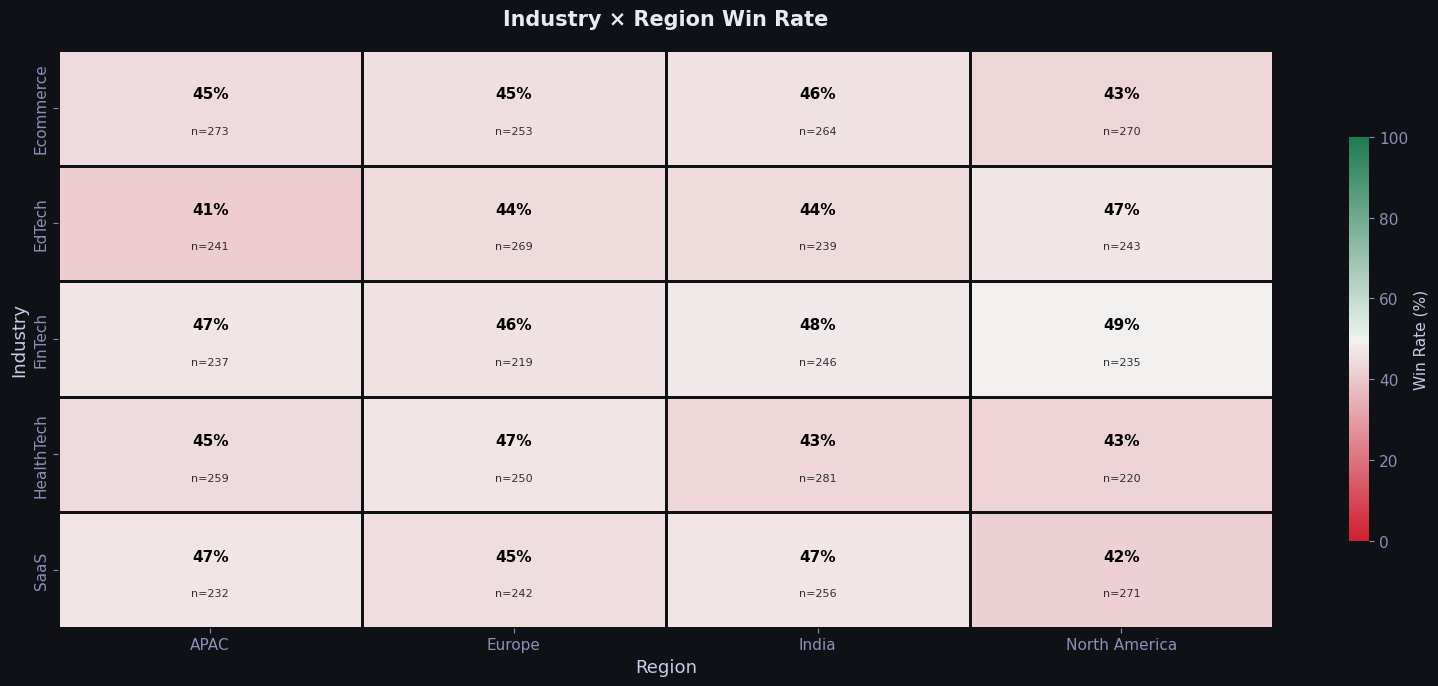

✅ Industry × Region heatmap saved


In [85]:
# ── GRAPH: Industry × Region Win Rate Heatmap ─────────────────────────────────

seg_wr  = calc_seg_wr
seg_cnt = calc_seg_cnt

fig, ax = plt.subplots(figsize=(16, 7), facecolor='#0F1117')
ax.set_facecolor('#1A1D2E')

cmap = sns.diverging_palette(10, 145, s=90, l=45, as_cmap=True)

sns.heatmap(
    seg_wr,
    ax=ax,
    cmap=cmap,
    center=50,
    vmin=0,
    vmax=100,
    linewidths=2,
    linecolor='#0F1117',
    annot=False,
    cbar_kws={'shrink': 0.7, 'label': 'Win Rate (%)'}
)

for r_idx, industry in enumerate(seg_wr.index):
    for c_idx, region in enumerate(seg_wr.columns):
        wr  = seg_wr.loc[industry, region]
        cnt = seg_cnt.loc[industry, region]

        if not pd.isna(wr) and not pd.isna(cnt):
            txt_color = 'black' if 30 < wr < 70 else 'white'
            ax.text(c_idx + 0.5, r_idx + 0.38, f'{wr:.0f}%',
                    ha='center', va='center', color=txt_color,
                    fontsize=11, fontweight='bold')
            ax.text(c_idx + 0.5, r_idx + 0.70, f'n={int(cnt)}',
                    ha='center', va='center', color=txt_color,
                    fontsize=8, alpha=0.8)

ax.set_title('Industry × Region Win Rate',
             fontsize=15, pad=18)
ax.set_xlabel('Region', fontsize=13)
ax.set_ylabel('Industry', fontsize=13)

plt.tight_layout()
plt.savefig('outputs/11_industry_region_heatmap.png', dpi=150,
            bbox_inches='tight', facecolor='#0F1117')
plt.show()

print('✅ Industry × Region heatmap saved')


Win rates vary by **industry × region** combination, but the spread is still relatively narrow (roughly **41%–49%**). This reinforces that there is no single “bad market” causing the overall win-rate decline; performance issues are **broad-based**.

There are, however, a few notable pockets:
- **FinTech × North America (49.36%)** is the strongest combination, approaching the 50% baseline.
- **EdTech × APAC (41.08%)** and **SaaS × North America (42.07%)** are clear underperformers.
- **HealthTech × Europe (47.20%)** performs relatively better than HealthTech in other regions, suggesting regional GTM fit differences.

Deal counts per cell are reasonably balanced (mostly **~220–280 deals**), so these differences are **not driven by tiny samples** and are operationally meaningful.

Business takeaway:
- Geographic targeting alone will not fix the win-rate problem, but **certain industry–region pairs are systematically weaker** and deserve tailored interventions.
- The signal emerges at the **intersection** of dimensions, not within single dimensions.

Action-wise:
- Prioritize focused playbooks for weak combinations (e.g., **EdTech in APAC**, **SaaS in North America**) rather than broad region-wide changes.
- Study best practices from strong pockets (e.g., **FinTech in North America**) and port winning motions to adjacent segments.
- Encode industry × region as interaction features in the decision engine so high-risk combinations receive additional scrutiny early in the funnel.


---
##  Monthly Volume & Win Rate — Seasonality Check

In [88]:
# ── CALC: Monthly Win Rate, Deal Count, Avg Deal Amount ────────────────────────
calc_monthly = (
    df.groupby('close_month')
      .agg(
          win_rate_pct=('won', lambda x: round(x.mean() * 100, 2)),
          deal_count=('won', 'count'),
          avg_amount_k=('deal_amount', lambda x: round(x.mean() / 1000, 2))
      )
      .reset_index()
)

month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']

calc_monthly['month_name'] = calc_monthly['close_month'].apply(lambda m: month_names[m-1])

print("=== CALC: Monthly Win Rate, Deal Count, Avg Deal Amount ===")
print(calc_monthly[['close_month','month_name','win_rate_pct','deal_count','avg_amount_k']].to_string(index=False))


=== CALC: Monthly Win Rate, Deal Count, Avg Deal Amount ===
 close_month month_name  win_rate_pct  deal_count  avg_amount_k
           1        Jan         46.96         345         23.50
           2        Feb         47.03         421         28.26
           3        Mar         44.93         552         25.54
           4        Apr         42.76         566         26.97
           5        May         46.76         586         24.91
           6        Jun         43.89         458         26.27
           7        Jul         44.30         386         27.88
           8        Aug         43.06         346         26.97
           9        Sep         41.53         313         27.30
          10        Oct         50.00         370         25.98
          11        Nov         46.15         325         26.29
          12        Dec         46.08         332         26.03


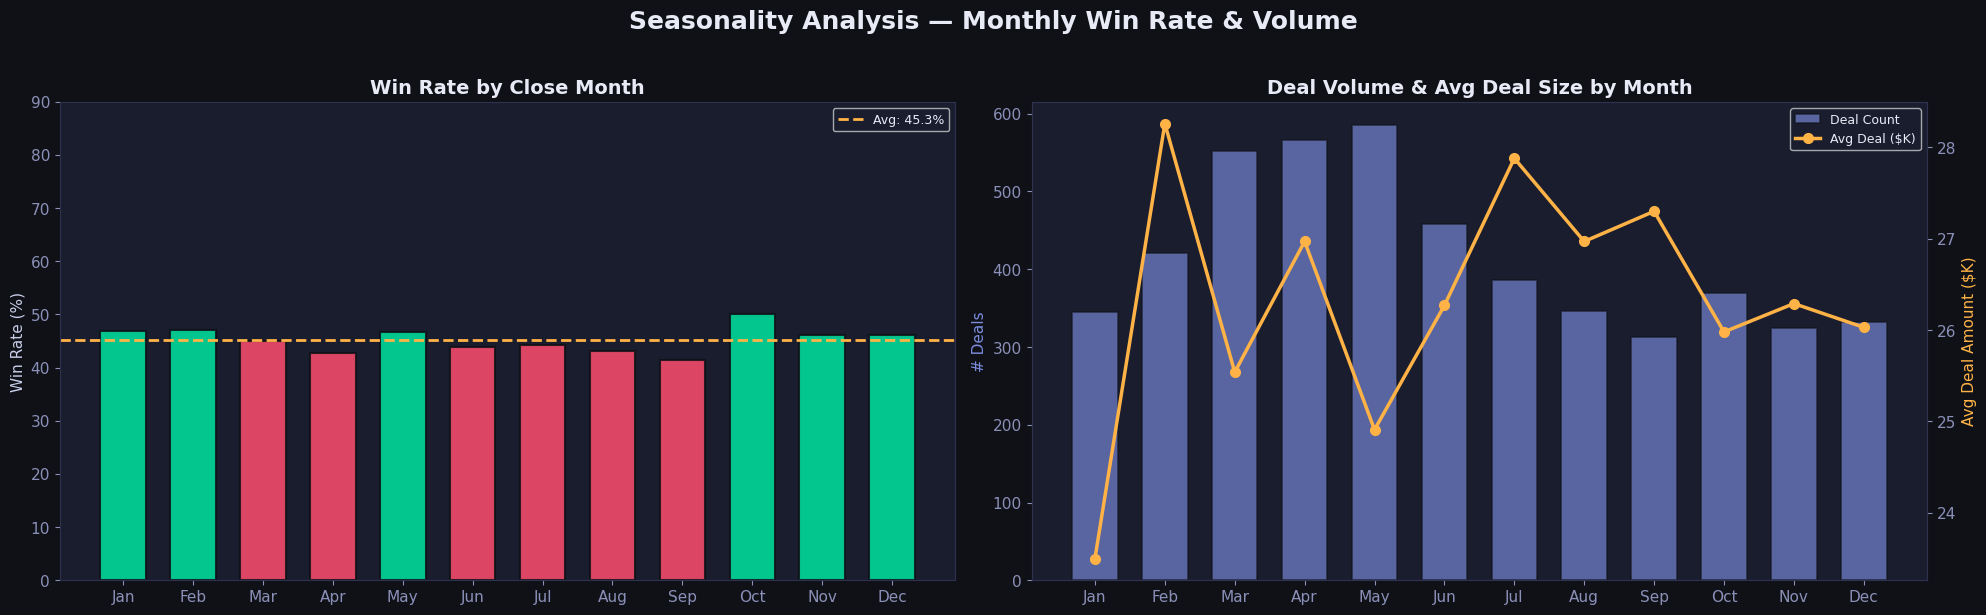

In [89]:
# ── GRAPH: Seasonality Analysis — Monthly Win Rate & Volume ───────────────────

fig, axes = plt.subplots(1, 2, figsize=(20, 6), facecolor='#0F1117')
fig.suptitle('Seasonality Analysis — Monthly Win Rate & Volume',
             fontsize=18, fontweight='bold', color='#E8EAF6', y=1.02)

# Sub-plot A: Win rate per month
ax = axes[0]

avg_wr = calc_monthly['win_rate_pct'].mean()
bar_cols = [WON_COLOR if v >= avg_wr else LOST_COLOR for v in calc_monthly['win_rate_pct']]

bars = ax.bar(calc_monthly['month_name'],
              calc_monthly['win_rate_pct'],
              color=bar_cols,
              alpha=0.85, edgecolor='#0F1117', linewidth=1.5, width=0.65)

ax.axhline(avg_wr, color=ACCENT2, linestyle='--',
           linewidth=2, label=f"Avg: {avg_wr:.1f}%")

ax.set_title('Win Rate by Close Month')
ax.set_ylabel('Win Rate (%)')
ax.set_ylim(0, 90)
ax.legend(fontsize=9)

# Sub-plot B: Deal volume vs avg amount per month
ax2 = axes[1]
ax2b = ax2.twinx()
ax2b.set_facecolor('#1A1D2E')

ax2.bar(calc_monthly['month_name'],
        calc_monthly['deal_count'],
        color=ACCENT, alpha=0.65,
        edgecolor='#0F1117', linewidth=1.2, width=0.65, label='Deal Count')

ax2b.plot(calc_monthly['month_name'],
          calc_monthly['avg_amount_k'],
          color=ACCENT2, marker='o',
          linewidth=2.5, markersize=7, label='Avg Deal ($K)')

ax2.set_title('Deal Volume & Avg Deal Size by Month')
ax2.set_ylabel('# Deals', color=ACCENT)
ax2b.set_ylabel('Avg Deal Amount ($K)', color=ACCENT2)

lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2b.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, fontsize=9)

plt.tight_layout()
plt.savefig('outputs/12_seasonality.png', dpi=150,
            bbox_inches='tight', facecolor='#0F1117')
plt.show()


Win rate shows mild **seasonality** across months, ranging from **~41.5% (Sep)** to **50.0% (Oct)**. Most months sit below the overall average, indicating that seasonality alone does **not explain the structural win-rate problem**, but it does create predictable troughs and peaks.

Clear weak months emerge:
- **September (41.53%)** and **April (42.76%)** are the lowest-converting months.
- These dips occur despite healthy deal volume (e.g., April: **566 deals**), suggesting the issue is **conversion quality**, not pipeline scarcity.

October stands out as a relative high point (**50.0% win rate**), but its performance is not sustained across adjacent months, indicating short-lived effects (e.g., budget cycles, end-of-quarter urgency) rather than durable process improvements.

Deal volume and average deal size are relatively stable month to month. This implies that win-rate variation is driven more by **buyer behavior and sales execution timing** than by major shifts in deal mix.

Business takeaway:
- Seasonality exists but is **secondary** to structural drivers of win rate.
- Predictable low-performing months represent opportunities for targeted interventions rather than excuses for poor performance.

Action-wise:
- Plan **conversion-boosting campaigns** (pricing nudges, exec involvement, urgency plays) ahead of historically weak months (e.g., Apr, Sep).
- Adjust forecasting and targets to account for seasonal dips while focusing improvement efforts on **process-level fixes** that persist across months.
- Use monthly seasonality as a control variable in performance reviews to avoid misattributing predictable dips to individual reps.


---
##  Insight Summary — Plain Business Language

In [92]:
print('=' * 70)
print('  SKYGENI EDA — KEY NUMBERS SUMMARY FOR THE CRO')
print('=' * 70)

overall_wr = round(df['won'].mean() * 100, 1)

q_trend = (
    df.groupby('close_quarter')['won']
      .mean()
      .mul(100)
      .round(1)
      .sort_index()
)

best_src  = df.groupby('lead_source')['won'].mean().idxmax()
worst_src = df.groupby('lead_source')['won'].mean().idxmin()

won_cyc  = round(df[df['won'] == 1]['sales_cycle_days'].mean(), 1)
lost_cyc = round(df[df['won'] == 0]['sales_cycle_days'].mean(), 1)

print(f"""
OVERALL WIN RATE (%)
{overall_wr}

WIN RATE BY QUARTER (%)
{q_trend.to_string()}

BEST LEAD SOURCE
{best_src}

WORST LEAD SOURCE
{worst_src}

AVG SALES CYCLE (DAYS)
Won  deals : {won_cyc}
Lost deals : {lost_cyc}
Cycle gap  : {round(lost_cyc - won_cyc, 1)}
""")

print('=' * 70)


  SKYGENI EDA — KEY NUMBERS SUMMARY FOR THE CRO

OVERALL WIN RATE (%)
45.3

WIN RATE BY QUARTER (%)
close_quarter
2023Q1    44.5
2023Q2    45.0
2023Q3    42.8
2023Q4    47.5
2024Q1    46.7
2024Q2    43.8
2024Q3    51.7

BEST LEAD SOURCE
Inbound

WORST LEAD SOURCE
Partner

AVG SALES CYCLE (DAYS)
Won  deals : 63.2
Lost deals : 64.2
Cycle gap  : 1.0



This summary consolidates the key signals a CRO cares about into a few actionable numbers:

- **Overall win rate is 45.3%**, confirming that conversion is structurally below the 50% baseline despite healthy pipeline volume.
- **Win rate is below 50% in 6 out of 7 quarters** (lowest at **42.8% in 2023Q3**), indicating a persistent conversion problem rather than a one-off dip. The apparent improvement in **2024Q3 (51.7%)** is based on very low volume and should not drive decisions.
- **Inbound is the best-performing lead source**, while **Partner is the worst**, validating that pipeline mix (channel quality) is a meaningful driver of win-rate drag.
- **Average sales cycle is similar for wins vs losses (63.2d vs 64.2d; ~1 day gap)**, showing that cycle length alone is not a strong predictor of outcome without considering deal size and context.

Executive takeaway:
- The core issue is **conversion quality**, not pipeline volume.
- The highest-leverage levers are **channel quality (reduce Partner drag, scale Inbound/Referral)** and **early-stage qualification rigor**.
- Operational metrics (DVES, RRPS) should be used to focus coaching and deal support on the highest-risk opportunities rather than broad, unfocused process changes.


Across all analyses, the win-rate decline is not driven by pipeline volume, geography, industry, or product mix in isolation. Pipeline volume is healthy and stable, yet win rate sits at **~45% overall** and remains **below 50% in 6 out of 7 quarters**, indicating a **structural conversion problem** rather than a top-of-funnel problem.

The losses are concentrated in **process and quality issues**:
- **Early-stage leakage is the biggest funnel problem**: the **Qualified stage (42.26%)** is the weakest conversion point, meaning too many low-quality deals are being allowed into the pipeline.
- **Channel mix is dragging conversion**: **Partner is the weakest lead source (43.95%)** and saw volume growth in periods where win rate declined, while **Inbound and Referral convert better and win larger deals**.
- **Revenue leakage is concentrated in large deals**: even with similar win rates across deal sizes, **30K+ deals account for the majority of lost revenue**, with the **60K+ bucket leaking ~$35.5M**. Small percentage improvements here would have outsized revenue impact.
- **Time-to-close alone is not the issue**, but **long-running large deals are riskier**: cycle length becomes a meaningful loss predictor when combined with ACV and industry.
- **Segment averages hide real execution variance**: rep-level performance varies meaningfully after controlling for territory difficulty (RRPS). Some reps consistently outperform their segment baseline by **+3 to +6 pp**, while others underperform by **−3 to −5 pp**, representing real coaching and enablement opportunities.
- **Deal quality and speed matter**: the custom metric **DVES (Deal Velocity Efficiency Score)** clearly separates wins from losses across industries and reps. Deals that generate **more revenue per day of sales effort** are materially more likely to close.

The root cause of the win-rate decline is therefore **not “wrong markets” or “not enough leads,” but weak deal selection and early-stage qualification, compounded by scaling lower-quality channels and under-managing large, complex opportunities**.

High-leverage actions implied by the data:
- Tighten **Qualified-stage entry criteria** and enforce minimum fit/intent checks.
- Rebalance channel mix away from **Partner and low-quality Outbound** toward **Inbound and Referral**, and add stricter gating for Partner-sourced Enterprise deals.
- Introduce **risk-based deal management for high-ACV opportunities** (exec sponsorship, deal coaching once cycle length crosses thresholds).
- Operationalize **DVES** for deal prioritization and **RRPS** for targeted rep coaching, so leadership interventions are focused on the highest-risk deals and the largest performance gaps.
- Shift reporting from raw win rate to **revenue-weighted metrics** to ensure leadership optimizes where revenue leakage is largest, not just where counts are highest.

In short:  
The win-rate problem is a **quality and execution problem, not a volume problem**. The fastest path to revenue uplift is improving **early-stage deal quality, channel mix, and large-deal conversion discipline**, supported by risk-aware metrics rather than broad, one-size-fits-all process changes.
